# Clasificador Bayesiano Multimodal para la categorización de noticias periodísticas  
Desarrollar y evaluar un clasificador Naive Bayes multimodal que asigne a cada artículo de un conjunto de datos de noticias su sección temática correspondiente, aplicando técnicas adecuadas de preprocesamiento, extracción de características textuales y evaluación.

Las secciones en las que se deberán categorizar las noticias (Taxonomía) son las siguientes:

- Deportes
- Internacional
- Nacional
- Sociedad

## Dataset proporcionado  
- Fichero `news_dataset`en formato CSV con las siguientes columnas: 

    - `Titular`: Título corto de la noticia.
    - `Cuerpo`: Texto completo de la noticia
    - `Categoría`: Categoría a la que pertenece

## Fases de trabajo
1. **Análisis exploratorio del dataset**  
   - Cargar los datos en un DataFrame de pandas.  
   - Observar métricas de balanceo: número de ejemplos por sección.
2. **Generación del conjunto de entrenamiento y el de pruebas** 
   - Utilizar la siguiente proporción 80% => Entrenamiento, 20% => Pruebas.
3. **Extracción y Preprocesamiento del texto**  
   - El texto del que se extrerán las carecterísticas será el formado por la combinación de Título + Cuerpo para cada una de las noticias.
4. **Diseño e implementación del clasificador Naive Bayes**  
5. **Evaluación y pruebas**  
   - Matriz de confusión
   - Exactitud general del calsificador.
   - Métricas por (precission, recall y f1-score)
      - Por Clase 
      - Agregadas (macro, micro, weighted): 
6. **Análisis y conclusiones**  

## Entregables
- Este mismo cuaderno Jupyter con la implementación de los pasos anteriormente descritos.

## Preparación del entorno

In [1]:
from collections import Counter
import string
import re

import pandas as pd
import numpy as np

# Descargamos los recursos necesarios de NLTK si es que no existen previamente en el entorno.
import nltk
try:
    nltk.data.find("tokenizers/punkt")
except LookupError:
    nltk.download("punkt", quiet=True)

try:
    nltk.data.find("tokenizers/punkt_tab")
except LookupError:
    nltk.download("punkt_tab", quiet=True)

try:
    nltk.data.find("corpora/stopwords")
except LookupError:
    nltk.download("stopwords")

# Módulos necesarios de NLTK que utilizaremos para el preprocesamiento de la información.
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Lematización
# Para que funcione la carga del modelo de lematización este tiene que estar descargado en el entorno primeramente.
# Para ello se puede utilizar alguna de las instrucciones siguientes desde tu entorno Python dependiendo del modelo de lematización que quieras utilizar:
# python -m spacy download es_core_news_sm (modelo pequeño)
# python -m spacy download es_core_news_md (modelo mediano)
import spacy
nlp = spacy.load("es_core_news_sm")
# nlp = spacy.load("es_core_news_md")

# Stemming
from nltk.stem import SnowballStemmer

# Módulos necesarios de la librería Scikit-Learn que vamos a utilizar para a construcción del modelo TF-IDF.
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC

# Representaciones gráficas varias 
import matplotlib.pyplot as plt
import seaborn as sns

# Persistencia de modelos
import joblib

## Configuración inicial del experimento

In [2]:
SPAM_DATASET= r"C:\Users\USUARIO\Documents\GitHub\tema-4-1-clasificacion-de-textos-y-deteccion-de-spam-maria2332\Clasificación Noticias\news_dataset.csv"
RANDOM_SEED = 202510                            # Semilla para la reproducibilidad de los resultados (No tocar para poder comparar resultados)

## Estudio del dataset de noticias

Número total de registros en el dataset: 400
Columnas del dataset: ['Titular', 'Cuerpo', 'Categoría']


,Titular,Cuerpo,Categoría
0,El Real Madrid vence al Barcelona en la Final ...,"En un partido lleno de emoción, el Real Madrid...",deportes
1,El Novak Djokovic gana su 21.º título de Grand...,Novak Djokovic superó a Carlos Alcaraz en una ...,deportes
2,El equipo femenino de fútbol de España gana la...,La Selección Femenina Española coronó su histo...,deportes
3,El campeón mundial de atletismo se retira desp...,Usain Bolt anunció su retiro tras haber ganado...,deportes
4,La selección argentina gana la Copa América en...,"Argentina, bajo la dirección de Lionel Scaloni...",deportes
...,...,...,...
395,La relevancia de los foros ciudadanos en la to...,Los residentes participan activamente en consu...,sociedad
396,El auge del turismo comunitario como motor de ...,Las iniciativas de ecoturismo generan ingresos...,sociedad
397,La importancia de los programas de alfabetizac...,Los cursos básicos sobre smartphones y redes s...,sociedad
398,El impacto del cambio climático en la disponib...,Las sequías prolongadas están alterando la ges...,sociedad


Distribución por categorías:
Categoría
deportes         100
internacional    100
nacional         100
sociedad         100
Name: count, dtype: int64
Distribución porcentual por categorías:
Categoría
deportes         25.0
internacional    25.0
nacional         25.0
sociedad         25.0
Name: count, dtype: float64


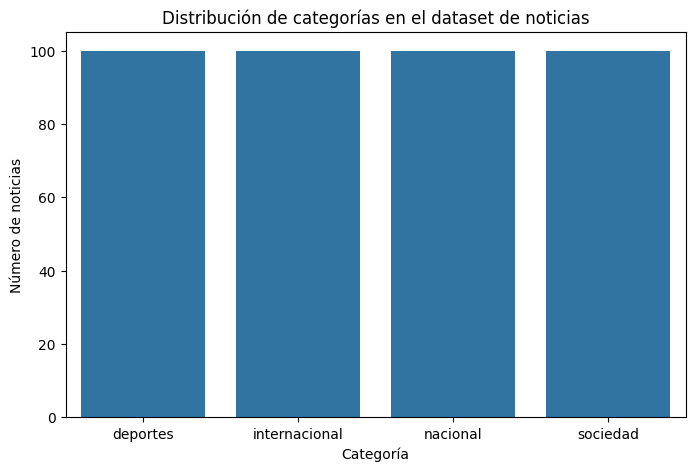

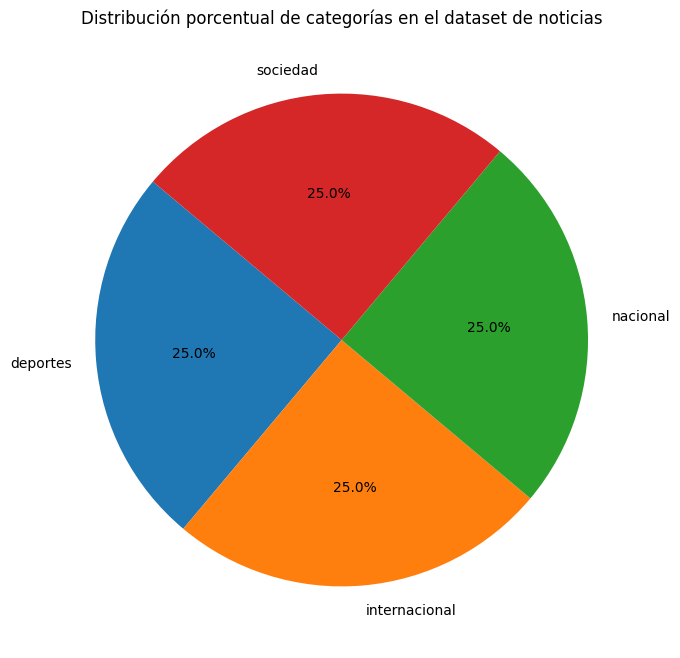

In [3]:
spam_df = pd.read_csv(SPAM_DATASET)

# Muestra total de registros
print("Número total de registros en el dataset:", spam_df.shape[0])

# Muestra las columnas del dataset
print("Columnas del dataset:", spam_df.columns.tolist())

# Muestra las primeras filas del dataset y la distribución de categorías
display(spam_df)
print("Distribución por categorías:")
print(spam_df['Categoría'].value_counts())

# Calculamos el porcentaje de cada categoría
total_registros = spam_df.shape[0]
distribucion_porcentaje = (spam_df['Categoría'].value_counts() / total_registros) * 100
print("Distribución porcentual por categorías:")
print(distribucion_porcentaje)

#grafica de barras de la distribución de categorías
plt.figure(figsize=(8, 5))
sns.countplot(data=spam_df, x='Categoría', order=spam_df['Categoría'].value_counts().index)
plt.title('Distribución de categorías en el dataset de noticias')
plt.xlabel('Categoría')
plt.ylabel('Número de noticias')
plt.show()

#grafico de pastel de la distribución de categorías
plt.figure(figsize=(8, 8))
spam_df['Categoría'].value_counts().plot.pie(autopct='%1.1f%%', startangle=140)
plt.title('Distribución porcentual de categorías en el dataset de noticias')
plt.ylabel('')
plt.show()

In [4]:
# buscar duplicados en el dataset, mismo título y mismo cuerpo
duplicados = spam_df.duplicated(subset=['Titular', 'Cuerpo'], keep=False)
print("Número de registros duplicados (mismo Titular y cuerpo):", duplicados.sum())
display(spam_df[duplicados].sort_values(by=['Titular', 'Cuerpo']))

# el que esta duplicado, cuantas veces aparece
duplicados_df = spam_df[duplicados]
conteo_duplicados = duplicados_df.groupby(['Titular', 'Cuerpo']).size().reset_index(name='Conteo')
print("Conteo de registros duplicados únicos:", conteo_duplicados.shape[0])
display(conteo_duplicados)



Número de registros duplicados (mismo Titular y cuerpo): 80


,Titular,Cuerpo,Categoría
237,El Congreso aprueba ley de protección de datos...,La nueva legislación impone requisitos estrict...,nacional
277,El Congreso aprueba ley de protección de datos...,La nueva legislación impone requisitos estrict...,nacional
241,El Senado debate reforma del sistema de salud ...,Se inició un debate sobre la reestructuración ...,nacional
281,El Senado debate reforma del sistema de salud ...,Se inició un debate sobre la reestructuración ...,nacional
372,El auge del comercio justo en la producción te...,Las cooperativas artesanales están certificánd...,sociedad
...,...,...,...
280,Política ambiental: nueva ley de protección de...,El gobierno aprobó una legislación que prohíbe...,nacional
242,Presidente anuncia plan de digitalización admi...,Hoy se anunció una inversión de 80 mil millone...,nacional
282,Presidente anuncia plan de digitalización admi...,Hoy se anunció una inversión de 80 mil millone...,nacional
238,Presidente firma decreto sobre control de prec...,Hoy se aprobó una medida temporal que limita e...,nacional


Conteo de registros duplicados únicos: 34


,Titular,Cuerpo,Conteo
0,El Congreso aprueba ley de protección de datos...,La nueva legislación impone requisitos estrict...,2
1,El Senado debate reforma del sistema de salud ...,Se inició un debate sobre la reestructuración ...,2
2,El auge del comercio justo en la producción te...,Las cooperativas artesanales están certificánd...,2
3,El auge del coworking para startups tecnológicas,Las nuevas plataformas de trabajo colaborativo...,2
4,El auge del turismo comunitario como motor de ...,Las iniciativas de ecoturismo generan ingresos...,2
5,"El campeón mundial de esgrima, Kim Min-Jae, ga...",El coreano venció a el argentino Gabriel Yunes...,3
6,"El campeón mundial de gimnasia, Kohei Uchimura...",El japonés venció al italiano Marco Rossi en l...,3
7,"El campeón mundial de salto con pértiga, Arman...",Duplantis superó a Yaroslav Rybakov en la fina...,4
8,"El campeón mundial de salto con pértiga, Renau...",Lavillenie superó a Yaroslav Rybakov en la fin...,2
9,El crecimiento de la economía circular en la i...,Las marcas están reciclando fibras y reutiliza...,2


In [5]:
# hay valores nulos en el dataset
valores_nulos = spam_df.isnull().sum()  
print("Valores nulos por columna:")
print(valores_nulos)


Valores nulos por columna:
Titular      0
Cuerpo       0
Categoría    0
dtype: int64


Estadísticas de longitud del Titular (palabras):
count    400.000000
mean      11.475000
std        2.821218
min        6.000000
25%       10.000000
50%       11.000000
75%       13.000000
max       19.000000
Name: longitud_titular, dtype: float64

Estadísticas de longitud del Cuerpo (palabras):
count    400.000000
mean      24.622500
std        8.495318
min       10.000000
25%       18.000000
50%       24.000000
75%       29.000000
max       70.000000
Name: longitud_cuerpo, dtype: float64


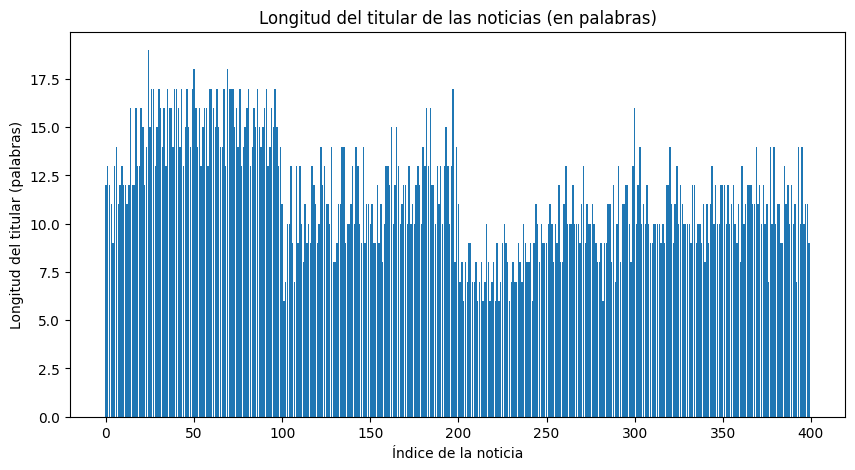

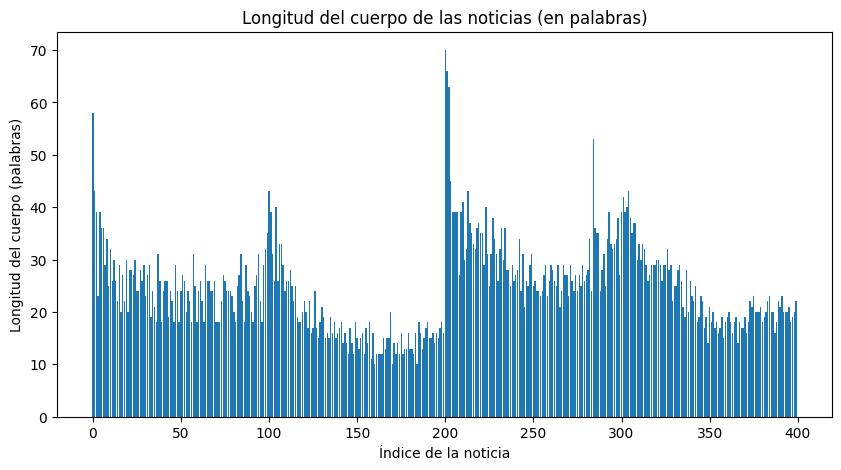

In [6]:
import matplotlib.pyplot as plt

# Longitud mínima, máxima y media del cuerpo y título de las noticias EN PALABRAS
spam_df['longitud_titular'] = spam_df['Titular'].astype(str).str.split().str.len()
spam_df['longitud_cuerpo'] = spam_df['Cuerpo'].astype(str).str.split().str.len()

print("Estadísticas de longitud del Titular (palabras):")
print(spam_df['longitud_titular'].describe())
print("\nEstadísticas de longitud del Cuerpo (palabras):")
print(spam_df['longitud_cuerpo'].describe())

# Gráfico de barras de la longitud del titular (en palabras)
plt.figure(figsize=(10, 5))
plt.bar(spam_df.index, spam_df['longitud_titular'])
plt.xlabel('Índice de la noticia')
plt.ylabel('Longitud del titular (palabras)')
plt.title('Longitud del titular de las noticias (en palabras)')
plt.show()

# Gráfico de barras de la longitud del cuerpo (en palabras)
plt.figure(figsize=(10, 5))
plt.bar(spam_df.index, spam_df['longitud_cuerpo'])
plt.xlabel('Índice de la noticia')
plt.ylabel('Longitud del cuerpo (palabras)')
plt.title('Longitud del cuerpo de las noticias (en palabras)')
plt.show()


In [7]:
# cuerpo más largo en palabras
indice_cuerpo_mas_largo = spam_df['longitud_cuerpo'].idxmax()
cuerpo_mas_largo = spam_df.loc[indice_cuerpo_mas_largo, 'Cuerpo']
num_palabras_cuerpo = spam_df.loc[indice_cuerpo_mas_largo, 'longitud_cuerpo']

print("Cuerpo más largo (índice {}):".format(indice_cuerpo_mas_largo))
print("Número de palabras en el cuerpo:", num_palabras_cuerpo)
print(cuerpo_mas_largo)
print("Categoría del cuerpo más largo:", spam_df.loc[indice_cuerpo_mas_largo, 'Categoría'])
print("\n")

# titular más largo en palabras
indice_titular_mas_largo = spam_df['longitud_titular'].idxmax()
titular_mas_largo = spam_df.loc[indice_titular_mas_largo, 'Titular']
num_palabras_titular = spam_df.loc[indice_titular_mas_largo, 'longitud_titular']

print("Titular más largo (índice {}):".format(indice_titular_mas_largo))
print("Número de palabras en el titular:", num_palabras_titular)
print(titular_mas_largo)
print("Categoría del titular más largo:", spam_df.loc[indice_titular_mas_largo, 'Categoría'])


Cuerpo más largo (índice 200):
Número de palabras en el cuerpo: 70
Tras un intenso debate parlamentario, el Congreso Nacional aprobó hoy una reforma tributaria destinada a aliviar la carga fiscal sobre los hogares de ingresos medios. La ley contempla reducciones en el impuesto sobre la renta para familias con ingresos entre 30 000 y 70 000 euros anuales, además de exenciones parciales para compras de vivienda nueva. Los legisladores argumentan que esta medida fomentará la demanda interna y estimulará la economía.
Categoría del cuerpo más largo: nacional


Titular más largo (índice 24):
Número de palabras en el titular: 19
Los torneos de tenis femenino del WTA celebran el triunfo de Serena Williams en un clásico contra Naomi Osaka
Categoría del titular más largo: deportes


               longitud_titular  longitud_cuerpo
Categoría                                       
deportes                  14.80            25.54
internacional             11.28            17.79
nacional                   8.99            31.49
sociedad                  10.83            23.67


<Figure size 800x500 with 0 Axes>

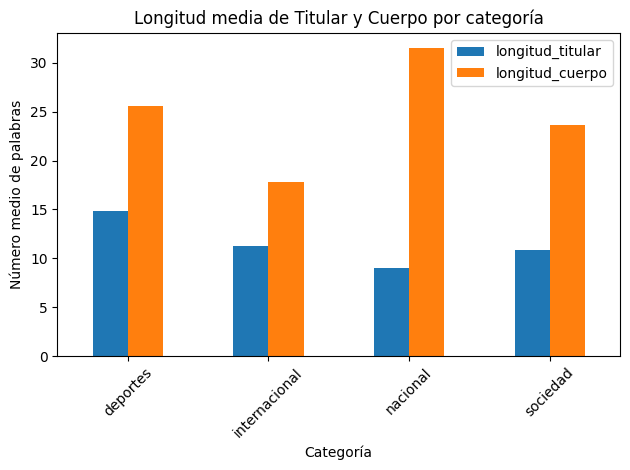

In [8]:
import matplotlib.pyplot as plt

# Agrupar por categoría y calcular la media de palabras
cat_stats = spam_df.groupby('Categoría')[['longitud_titular', 'longitud_cuerpo']].mean()

print(cat_stats)

# Gráfico de barras
plt.figure(figsize=(8, 5))
cat_stats.plot(kind='bar')
plt.xlabel('Categoría')
plt.ylabel('Número medio de palabras')
plt.title('Longitud media de Titular y Cuerpo por categoría')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<Figure size 800x500 with 0 Axes>

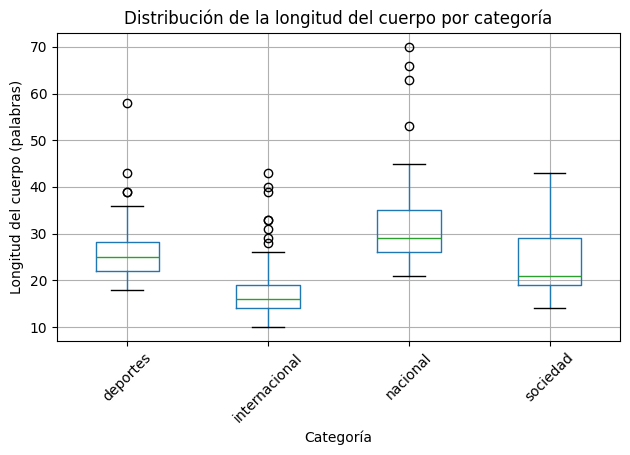

<Figure size 800x500 with 0 Axes>

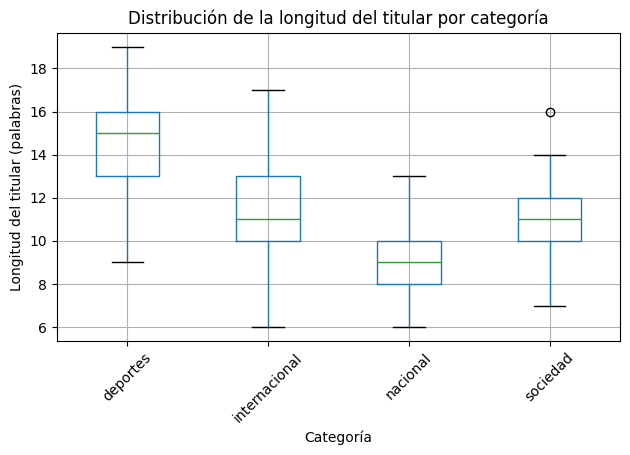

In [9]:
# Boxplot de la longitud del cuerpo por categoría
plt.figure(figsize=(8, 5))
spam_df.boxplot(column='longitud_cuerpo', by='Categoría')
plt.xlabel('Categoría')
plt.ylabel('Longitud del cuerpo (palabras)')
plt.title('Distribución de la longitud del cuerpo por categoría')
plt.suptitle('')  
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Boxplot de la longitud del titular por categoría
plt.figure(figsize=(8, 5))
spam_df.boxplot(column='longitud_titular', by='Categoría')
plt.xlabel('Categoría')
plt.ylabel('Longitud del titular (palabras)')
plt.title('Distribución de la longitud del titular por categoría')
plt.suptitle('')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [10]:
# similitud de coseno entre titulares y cuerpos de noticias
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(spam_df['Titular'] + " " + spam_df['Cuerpo'])
cosine_sim = cosine_similarity(tfidf_matrix)
print("Matriz de similitud de coseno entre titulares y cuerpos de noticias:")
print(cosine_sim)

Matriz de similitud de coseno entre titulares y cuerpos de noticias:
[[1.         0.09009694 0.10054007 ... 0.03511322 0.0251074  0.02885306]
 [0.09009694 1.         0.07827161 ... 0.02514191 0.02229486 0.02795639]
 [0.10054007 0.07827161 1.         ... 0.04962037 0.04038141 0.05428175]
 ...
 [0.03511322 0.02514191 0.04962037 ... 1.         0.02434465 0.04782593]
 [0.0251074  0.02229486 0.04038141 ... 0.02434465 1.         0.02749584]
 [0.02885306 0.02795639 0.05428175 ... 0.04782593 0.02749584 1.        ]]


In [11]:
# 1. Construir el texto combinado (Titular + Cuerpo)
spam_df["texto_completo"] = spam_df["Titular"].astype(str) + " " + spam_df["Cuerpo"].astype(str)

# 2. Vectorizar con TF-IDF 
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(spam_df["texto_completo"])

# 3. Calcular la matriz de similitud de coseno
cosine_sim = cosine_similarity(tfidf_matrix)
print("Matriz de similitud de coseno entre noticias (shape={}):".format(cosine_sim.shape))

# 4. Buscar pares de noticias near-duplicate según un umbral
umbral = 0.9  
n = cosine_sim.shape[0]
pairs = []

for i in range(n):
    for j in range(i + 1, n):  # solo parte superior de la matriz
        if cosine_sim[i, j] >= umbral:
            pairs.append((i, j, cosine_sim[i, j]))

print(f"\nEncontrados {len(pairs)} pares con similitud >= {umbral}")

# 5. Ordenar pares por similitud (de mayor a menor) y mostrar los primeros
pairs_sorted = sorted(pairs, key=lambda x: x[2], reverse=True)

for i, j, sim in pairs_sorted[:10]:  
    print("\n---")
    print(f"Índices: {i} - {j} | similitud: {sim:.3f}")
    print("Titular 1:", spam_df.loc[i, "Titular"])
    print("Titular 2:", spam_df.loc[j, "Titular"])
    print("Cuerpo 1:", spam_df.loc[i, "Cuerpo"])
    print("Cuerpo 2:", spam_df.loc[j, "Cuerpo"])


Matriz de similitud de coseno entre noticias (shape=(400, 400)):

Encontrados 68 pares con similitud >= 0.9

---
Índices: 81 - 91 | similitud: 1.000
Titular 1: Los torneos de fútbol juvenil de Grecia celebran su primer campeonato mundial masculino tras vencer a Italia
Titular 2: Los torneos de fútbol juvenil de Grecia celebran su primer campeonato mundial masculino tras vencer a Italia
Cuerpo 1: Los griegos lograron la remontada final, gracias al gol decisivo del jugador Nikos Papadopoulos en el último minuto.
Cuerpo 2: Los griegos lograron la remontada final, gracias al gol decisivo del jugador Nikos Papadopoulos en el último minuto.

---
Índices: 379 - 395 | similitud: 1.000
Titular 1: La relevancia de los foros ciudadanos en la toma de decisiones sobre transporte público
Titular 2: La relevancia de los foros ciudadanos en la toma de decisiones sobre transporte público
Cuerpo 1: Los residentes participan activamente en consultas públicas que determinan rutas y horarios, aumentando la

## Definicion del conjunto de entrenamiento y pruebas

In [12]:
def split_dataset(dataset= None, stratify_column= None, test_size=0.2, random_state=RANDOM_SEED):
    """ 
    Divide el dataset en conjuntos de entrenamiento y test.
    Mantiene la proporción de registros (test_size) dependiendo del valor del valor del parámetro stratify_column.

    Parámetros:
        dataset (DataFrame): El DataFrame completo a dividir.
        stratify_column (str): El nombre de la columna para estratificar.
        test_size (float): La proporción del dataset que se destina a test.
        random_state (int): Semilla para la reproducibilidad.
    """
    train_df, test_df = train_test_split(
        dataset, 
        test_size=test_size, 
        stratify= dataset[stratify_column], 
        random_state=RANDOM_SEED
    )
    return train_df, test_df


stratify_column= "Categoría"

# Genera los conjuntos de entrenamiento y test
train_df, test_df = split_dataset(
    dataset= spam_df,
    test_size= 0.2, # Especificamos un 20% del total del dataset original para el conjunto de pruebas.
    stratify_column= stratify_column
)
# Muestra los datasets generados para entrenamiento y test.
print("\nConjunto de Entrenamiento:")
print(train_df[stratify_column].value_counts())
display(train_df)
print("\nConjunto de Test:")
print(test_df[stratify_column].value_counts())
display(test_df)


Conjunto de Entrenamiento:
Categoría
nacional         80
sociedad         80
deportes         80
internacional    80
Name: count, dtype: int64


,Titular,Cuerpo,Categoría,longitud_titular,longitud_cuerpo,texto_completo
204,El Senado debate la reforma del sistema judicial,El Senado inició el debate sobre una propuesta...,nacional,8,39,El Senado debate la reforma del sistema judici...
345,El aumento de la participación ciudadana en la...,Los planes participativos han permitido a los ...,sociedad,10,23,El aumento de la participación ciudadana en la...
308,Programa de alfabetización digital para adulto...,La iniciativa “Conectados” brinda capacitación...,sociedad,10,37,Programa de alfabetización digital para adulto...
240,Política ambiental: nueva ley de protección de...,El gobierno aprobó una legislación que prohíbe...,nacional,8,27,Política ambiental: nueva ley de protección de...
15,Los torneos de golf de Augusta celebran la vic...,Spieth se coronó campeón del Masters tras supe...,deportes,12,29,Los torneos de golf de Augusta celebran la vic...
...,...,...,...,...,...,...
120,El presidente de Pakistán anuncia la reforma e...,La iniciativa busca mejorar la calidad de la e...,internacional,9,22,El presidente de Pakistán anuncia la reforma e...
263,Ministerio de Cultura expone plan de digitaliz...,El ministro anunció un proyecto para escanear ...,nacional,10,25,Ministerio de Cultura expone plan de digitaliz...
206,Política fiscal: debate sobre la eliminación d...,Se abrió un debate parlamentario sobre la prop...,nacional,9,39,Política fiscal: debate sobre la eliminación d...
322,Desafíos de la integración laboral de refugiad...,Los datos indican que los refugiados enfrentan...,sociedad,9,29,Desafíos de la integración laboral de refugiad...



Conjunto de Test:
Categoría
sociedad         20
deportes         20
internacional    20
nacional         20
Name: count, dtype: int64


,Titular,Cuerpo,Categoría,longitud_titular,longitud_cuerpo,texto_completo
350,La influencia de las políticas de igualdad sal...,Los ajustes en los salarios han reducido la ro...,sociedad,12,21,La influencia de las políticas de igualdad sal...
0,El Real Madrid vence al Barcelona en la Final ...,"En un partido lleno de emoción, el Real Madrid...",deportes,12,58,El Real Madrid vence al Barcelona en la Final ...
132,El presidente de México propone reformas fisca...,El plan incluye reducciones de impuestos a pym...,internacional,11,15,El presidente de México propone reformas fisca...
213,Nuevo pacto social propuesto por el partido pr...,"El líder del Partido Progresista, Carlos Díaz,...",nacional,8,43,Nuevo pacto social propuesto por el partido pr...
382,El impacto del cambio climático en la disponib...,Las sequías prolongadas están alterando la ges...,sociedad,11,20,El impacto del cambio climático en la disponib...
...,...,...,...,...,...,...
374,El crecimiento del acceso a agua potable media...,Las comunidades rurales están instalando filtr...,sociedad,10,21,El crecimiento del acceso a agua potable media...
287,Gobierno presenta plan de fomento al emprendim...,El gobierno anunció un programa de apoyo finan...,nacional,8,35,Gobierno presenta plan de fomento al emprendim...
247,Ministerio de Ciencia expone plan de investiga...,El ministro anunció un proyecto para investiga...,nacional,10,25,Ministerio de Ciencia expone plan de investiga...
219,El Senado aprueba ley de transparencia electoral,Hoy se aprobó una nueva legislación que obliga...,nacional,7,37,El Senado aprueba ley de transparencia elector...


## Funcion de preprocesamiento del texto

In [13]:
def preprocesar_documento(documento):
    """
    Función para preprocesar un documento individual
    
    Args:
        documento (str): Texto del documento a preprocesar
    
    Returns:
        list: Lista de tokens normalizados para el texto a preprocesar.
    """
    documento = documento.lower()
    
    # Eliminar signos de puntuación usando expresiones regulares
    # documento = re.sub(r'[^\w\s]', '', documento)
    
    # Tokenizar usando NLTK
    tokens = word_tokenize(documento, language='spanish')

    # Eliminación de puntuación y stopwords
    stop_words = set(stopwords.words("spanish"))
    tokens_limpios = [t for t in tokens if t not in string.punctuation and t not in stop_words]
    
    # Filtrar tokens que no sean alfabéticos (eliminar números)
    tokens_filtrados = [token for token in tokens_limpios if token.isalpha()]

    # Lamtización usando spaCy
    doc_spacy = nlp(" ".join(tokens_filtrados))
    tokens_lemmatizados = [token.lemma_ for token in doc_spacy] 
    
    return tokens_lemmatizados

In [14]:
train_documentos_procesados = []
for i, fila in train_df.iterrows():
    texto_combinado = f"{fila['Titular']} {fila['Cuerpo']}"
    tokens = preprocesar_documento(texto_combinado)
    train_documentos_procesados.append(" ".join(tokens))

# Número de documentos de entrenamiento procesados
print(f"Número de documentos de entrenamiento procesados: {len(train_documentos_procesados)}")
print(f"Documentos de entrenamiento procesados: {train_documentos_procesados[:3]}...")

Número de documentos de entrenamiento procesados: 320
Documentos de entrenamiento procesados: ['senado debate reforma sistema judicial senado iniciar debate propuesto reforma buscar modernizar sistema judicial reducir plazo procesal caso civil penal defensor argumentar eficiencia crítico temer pérdido garantía procesal víctima', 'aumento participación ciudadano planificación urbano plan participativo permitido residente influir directamente proyecto infraestructuro generar mayor aceptación satisfacción desarrollo urbano', 'programa alfabetización digital adulto mayor alcanzar participante iniciativo conectado brindar capacitación uso básico computadora internet persona mayor año mejorado acceso servicio público red social campaña extender nivel nacional']...


In [15]:
# Crea el vectorizador TF-IDF
tfidf_vectorizer = TfidfVectorizer (
    stop_words=None, 
    ngram_range= (1,1),
    analyzer='word',
    max_df=0.5,
    min_df=1,
    max_features= None
)

X_train_tfidf_full = tfidf_vectorizer.fit_transform(raw_documents=train_documentos_procesados)

# Muestra el tamaño de la matriz TF-IDF
print("Tamaño de la matriz TF-IDF:", X_train_tfidf_full.shape)
# Muestra algunas características del vectorizador TF-IDF
print("Número de características (palabras únicas) en el vocabulario TF-IDF:", len(tfidf_vectorizer.vocabulary_))
print("Características (primeras 10 palabras TF-IDF):", list(tfidf_vectorizer.vocabulary_.keys())[:10])

Tamaño de la matriz TF-IDF: (320, 1852)
Número de características (palabras únicas) en el vocabulario TF-IDF: 1852
Características (primeras 10 palabras TF-IDF): ['senado', 'debate', 'reforma', 'sistema', 'judicial', 'iniciar', 'propuesto', 'buscar', 'modernizar', 'reducir']


# Entrenamiento del modelo NB por conteo

In [ ]:
# Vectorizamos los documentos de entrenamiento usando CountVectorizer
vectorizer_count = CountVectorizer()
X_train_counts_full = vectorizer_count.fit_transform(train_documentos_procesados)

# Entrenamos el clasificador Naive Bayes usando los datos vectorizados por conteo
clf_count_full = MultinomialNB(
    alpha=1.0,
    force_alpha=True,
    fit_prior=True,
    class_prior=None,
)

clf_count_full.fit(X_train_counts_full, train_df['Categoría'])

# Mostramos algunos aspectos del modelo entrenado
print("Clases del modelo NB por conteo entrenado:", clf_count_full.classes_)

# Muestra top frecuencias del modelo por conteo
feature_counts = np.asarray(X_train_counts_full.sum(axis=0)).flatten()
feature_names = vectorizer_count.get_feature_names_out()
feature_freq = list(zip(feature_names, feature_counts))  # Lista de tuplas (palabra, frecuencia)
feature_freq.sort(key=lambda x: x[1], reverse=True)

print("\nTop 10 palabras más frecuentes (modelo por conteo)")
print("------------------------------")
for word, freq in feature_freq[:10]:
    print(f"{word}: {freq}")

print("\nTop 10 palabras menos frecuentes (modelo por conteo)")
print("------------------------------")
for word, freq in feature_freq[-10:]:
    print(f"{word}: {freq}")


Clases del modelo NB por conteo entrenado: ['deportes' 'internacional' 'nacional' 'sociedad']

Top 10 palabras más frecuentes (modelo por conteo)
------------------------------
final: 66
mundial: 63
ganar: 62
vencer: 60
anunciar: 56
tras: 51
público: 50
plan: 46
presidente: 42
reducir: 42

Top 10 palabras menos frecuentes (modelo por conteo)
------------------------------
yvonne: 1
zhonghua: 1
ámbito: 1
ángel: 1
árida: 1
épica: 1
épico: 1
índice: 1
öberg: 1
único: 1


## Entrenamiento del modelo tf-idf

In [10]:
# Vectorizamos los documentos de test usando TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf_full = tfidf_vectorizer.fit_transform(raw_documents=train_documentos_procesados)

# Entrenamos el clasificador NB usando los datos vectorizados por TF-IDF
clf_tfidf_full = MultinomialNB (
    alpha= 1.0,
    force_alpha= True,
    fit_prior= True, 
    class_prior= None,
)
clf_tfidf_full.fit(X_train_tfidf_full, train_df['Categoría'])

# Mostramos algunos aspectos del modelo entrenado.

print("Clases del modelo NB por TF-IDF entrenado:", clf_tfidf_full.classes_)

# Muestra top frecuencias del modelo TF-IDF
feature_counts = np.asarray(X_train_tfidf_full.sum(axis=0)).flatten()
feature_names = tfidf_vectorizer.get_feature_names_out()
feature_freq = list(zip(feature_names, feature_counts)) # Lista de tuplas (palabra, frecuencia)
feature_freq.sort(key=lambda x: x[1], reverse=True)
print("Top 10 palabras más frecuentes (modelo TF-IDF)")
print("------------------------------")
for word, freq in feature_freq[:10]:
    print(f"{word}: {freq}")
print("Top 10 palabras menos frecuentes (modelo TF-IDF)")
print("------------------------------")
for word, freq in feature_freq[-10:]:   
    print(f"{word}: {freq}")

Clases del modelo NB por TF-IDF entrenado: ['deportes' 'internacional' 'nacional' 'sociedad']
Top 10 palabras más frecuentes (modelo TF-IDF)
------------------------------
final: 8.01670340999927
mundial: 7.906969087461873
anunciar: 7.861149546469062
vencer: 7.611848251993834
ganar: 7.302186865104803
plan: 6.7883133875502635
público: 6.770568331691159
tras: 6.515226212249412
presidente: 6.190777364510847
reducir: 5.775517123303238
Top 10 palabras menos frecuentes (modelo TF-IDF)
------------------------------
agosto: 0.16615863306229098
cifra: 0.16615863306229098
conferencia: 0.16615863306229098
controlar: 0.16615863306229098
interés: 0.16615863306229098
ligeramente: 0.16615863306229098
ministra: 0.16615863306229098
prensa: 0.16615863306229098
subida: 0.16615863306229098
tipos: 0.16615863306229098


In [11]:
# Preprocesamos los documentos del conjunto de test
test_documentos_procesados = []
for i, fila in test_df.iterrows():
    texto_combinado = f"{fila['Titular']} {fila['Cuerpo']}"
    tokens = preprocesar_documento(texto_combinado)
    test_documentos_procesados.append(" ".join(tokens))

# Número de documentos de test procesados
print(f"Número de documentos de test procesados: {len(test_documentos_procesados)}")
print(f"Documentos de test procesados: {test_documentos_procesados[:3]}...")  # Muestra los primeros 3 documentos procesados


Número de documentos de test procesados: 80
Documentos de test procesados: ['influencia política igualdad salarial retención laboral ajuste salario reducido rotación personal femenino mejorar estabilidad productividad empresa privado', 'real madrid vence barcelona final laligar partido lleno emoción real madrid lograr victoria contundente rival histórico barcelona gol llegar largo encuentro vinícius júnior abrir marcador tiro libre magistral luego karim benzemo sellar ventaja segundo tiempo finalmente rodrygo añadir gol dejar público enloquecido', 'presidente méxico proponer reforma fiscal impulsar economía plan incluir reducción impuesto pym nuevo regulación grande conglomerado']...


## Evaluacion del modelo NB por conteo

In [12]:
# Evaluamos el modelo NB por conteo
X_test_counts_full = vectorizer_count.transform(test_documentos_procesados)
y_test_pred_count_full = clf_count_full.predict(X_test_counts_full)
accuracy_count_full = accuracy_score(test_df['Categoría'], y_test_pred_count_full)
print(f"Exactitud del modelo NB por conteo en el conjunto de test: {accuracy_count_full:.4f}")

# Evaluamos el modelo NB por TF-IDF
X_test_tfidf_full = tfidf_vectorizer.transform(test_documentos_procesados)
y_test_pred_tfidf_full = clf_tfidf_full.predict(X_test_tfidf_full)
accuracy_tfidf_full = accuracy_score(test_df['Categoría'], y_test_pred_tfidf_full)
print(f"Exactitud del modelo NB por TF-IDF en el conjunto de test: {accuracy_tfidf_full:.4f}")


Exactitud del modelo NB por conteo en el conjunto de test: 0.9625
Exactitud del modelo NB por TF-IDF en el conjunto de test: 0.9250


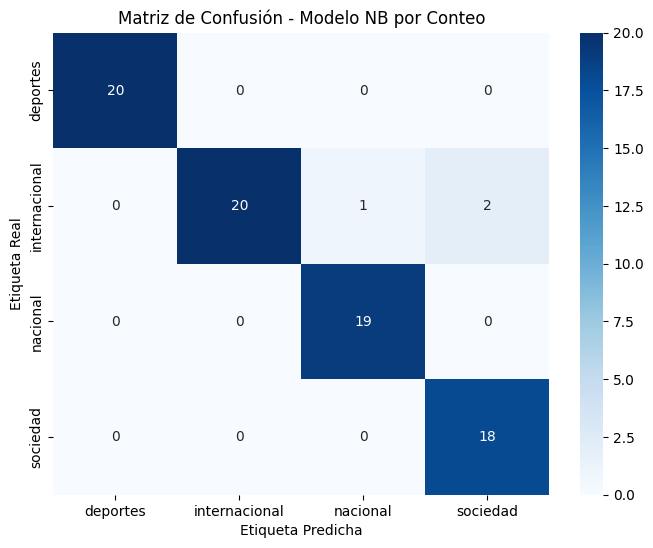

In [13]:
# Calcula y muestra la matriz de confusión para el modelo NB por conteo
confusion_mat_count_full = confusion_matrix(test_df['Categoría'], y_test_pred_count_full)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat_count_full.T, annot=True, fmt="d", cmap="Blues",
            xticklabels=clf_count_full.classes_,
            yticklabels=clf_count_full.classes_)
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.title('Matriz de Confusión - Modelo NB por Conteo')
plt.show()


In [14]:
# Muestra el resto de métricas de evaluación para el modelo NB por conteo
print("Métricas de evaluación para el modelo NB por conteo:")
print(classification_report(
    test_df['Categoría'], 
    y_test_pred_count_full, 
    target_names=clf_count_full.classes_, 
    zero_division=0, 
    digits=4
))


Métricas de evaluación para el modelo NB por conteo:
               precision    recall  f1-score   support

     deportes     1.0000    1.0000    1.0000        20
internacional     0.8696    1.0000    0.9302        20
     nacional     1.0000    0.9500    0.9744        20
     sociedad     1.0000    0.9000    0.9474        20

     accuracy                         0.9625        80
    macro avg     0.9674    0.9625    0.9630        80
 weighted avg     0.9674    0.9625    0.9630        80



In [15]:
# Cálculo de precisión, recall y F1-score con diferentes promedios
precision_count_full_macro = precision_score(test_df['Categoría'], y_test_pred_count_full, average='macro', zero_division=0)
recall_count_full_macro = recall_score(test_df['Categoría'], y_test_pred_count_full, average='macro', zero_division=0)
f1_count_full_macro = f1_score(test_df['Categoría'], y_test_pred_count_full, average='macro', zero_division=0)
print(f"Macro Average - Precision: {precision_count_full_macro:.4f}, Recall: {recall_count_full_macro:.4f}, F1-score: {f1_count_full_macro:.4f}")

precision_count_full_micro = precision_score(test_df['Categoría'], y_test_pred_count_full, average='micro', zero_division=0)
recall_count_full_micro = recall_score(test_df['Categoría'], y_test_pred_count_full, average='micro', zero_division=0)
f1_count_full_micro = f1_score(test_df['Categoría'], y_test_pred_count_full, average='micro', zero_division=0)
print(f"Micro Average - Precision: {precision_count_full_micro:.4f}, Recall: {recall_count_full_micro:.4f}, F1-score: {f1_count_full_micro:.4f}")

precision_count_full_weighted = precision_score(test_df['Categoría'], y_test_pred_count_full, average='weighted', zero_division=0)
recall_count_full_weighted = recall_score(test_df['Categoría'], y_test_pred_count_full, average='weighted', zero_division=0)
f1_count_full_weighted = f1_score(test_df['Categoría'], y_test_pred_count_full, average='weighted', zero_division=0)
print(f"Weighted Average - Precision: {precision_count_full_weighted:.4f}, Recall: {recall_count_full_weighted:.4f}, F1-score: {f1_count_full_weighted:.4f}")


Macro Average - Precision: 0.9674, Recall: 0.9625, F1-score: 0.9630
Micro Average - Precision: 0.9625, Recall: 0.9625, F1-score: 0.9625
Weighted Average - Precision: 0.9674, Recall: 0.9625, F1-score: 0.9630


In [16]:
# Muestra los documentos mal clasificados por el modelo NB por conteo
test_df['Predicción'] = y_test_pred_count_full
misclassified_count_full = test_df[test_df['Categoría'] != test_df['Predicción']]
display(misclassified_count_full[['Titular', 'Cuerpo', 'Categoría', 'Predicción']])


,Titular,Cuerpo,Categoría,Predicción
382,El impacto del cambio climático en la disponib...,Las sequías prolongadas están alterando la ges...,sociedad,internacional
225,Presidente anuncia medidas para la lucha contr...,El mandatario anunció nuevas políticas de audi...,nacional,internacional
398,El impacto del cambio climático en la disponib...,Las sequías prolongadas están alterando la ges...,sociedad,internacional


## Evaluacion del modelo tf-idf

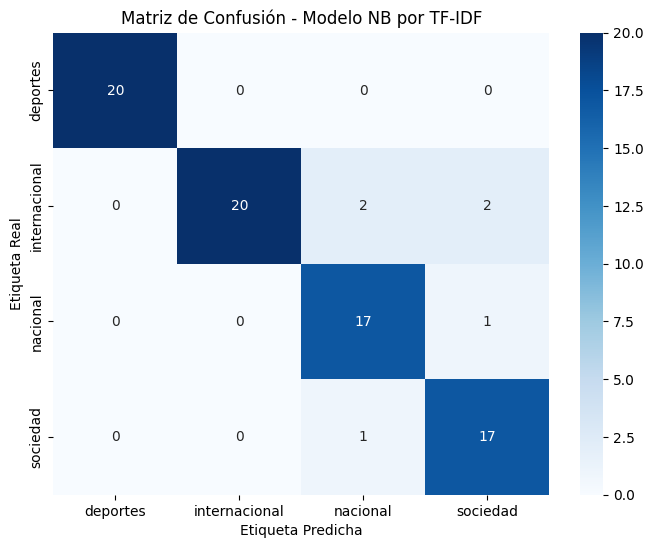

In [17]:
# Calcula y muestra la matriz de confusión para el modelo NB por TF-IDF
confusion_mat_tfidf_full = confusion_matrix(test_df['Categoría'], y_test_pred_tfidf_full)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat_tfidf_full.T, annot=True, fmt="d", cmap="Blues",
            xticklabels=clf_tfidf_full.classes_,
            yticklabels=clf_tfidf_full.classes_)
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.title('Matriz de Confusión - Modelo NB por TF-IDF')
plt.show()


In [18]:
# Muestra el reporte de clasificación para el modelo NB por TF-IDF
print("Métricas de evaluación para el modelo NB por TF-IDF:")
print(classification_report(
    test_df['Categoría'],
    y_test_pred_tfidf_full,
    target_names=clf_tfidf_full.classes_,
    zero_division=0,
    digits=4
))


Métricas de evaluación para el modelo NB por TF-IDF:
               precision    recall  f1-score   support

     deportes     1.0000    1.0000    1.0000        20
internacional     0.8333    1.0000    0.9091        20
     nacional     0.9444    0.8500    0.8947        20
     sociedad     0.9444    0.8500    0.8947        20

     accuracy                         0.9250        80
    macro avg     0.9306    0.9250    0.9246        80
 weighted avg     0.9306    0.9250    0.9246        80



In [19]:
# Cálculo de precisión, recall y F1-score con diferentes promedios para NB por TF-IDF

precision_tfidf_full_macro = precision_score(test_df['Categoría'], y_test_pred_tfidf_full,
                                             average='macro', zero_division=0)
recall_tfidf_full_macro = recall_score(test_df['Categoría'], y_test_pred_tfidf_full,
                                       average='macro', zero_division=0)
f1_tfidf_full_macro = f1_score(test_df['Categoría'], y_test_pred_tfidf_full,
                               average='macro', zero_division=0)
print(f"Macro Average - Precision: {precision_tfidf_full_macro:.4f}, Recall: {recall_tfidf_full_macro:.4f}, F1-score: {f1_tfidf_full_macro:.4f}")

precision_tfidf_full_micro = precision_score(test_df['Categoría'], y_test_pred_tfidf_full,
                                             average='micro', zero_division=0)
recall_tfidf_full_micro = recall_score(test_df['Categoría'], y_test_pred_tfidf_full,
                                       average='micro', zero_division=0)
f1_tfidf_full_micro = f1_score(test_df['Categoría'], y_test_pred_tfidf_full,
                               average='micro', zero_division=0)
print(f"Micro Average - Precision: {precision_tfidf_full_micro:.4f}, Recall: {recall_tfidf_full_micro:.4f}, F1-score: {f1_tfidf_full_micro:.4f}")

precision_tfidf_full_weighted = precision_score(test_df['Categoría'], y_test_pred_tfidf_full,
                                                average='weighted', zero_division=0)
recall_tfidf_full_weighted = recall_score(test_df['Categoría'], y_test_pred_tfidf_full,
                                          average='weighted', zero_division=0)
f1_tfidf_full_weighted = f1_score(test_df['Categoría'], y_test_pred_tfidf_full,
                                  average='weighted', zero_division=0)
print(f"Weighted Average - Precision: {precision_tfidf_full_weighted:.4f}, Recall: {recall_tfidf_full_weighted:.4f}, F1-score: {f1_tfidf_full_weighted:.4f}")


Macro Average - Precision: 0.9306, Recall: 0.9250, F1-score: 0.9246
Micro Average - Precision: 0.9250, Recall: 0.9250, F1-score: 0.9250
Weighted Average - Precision: 0.9306, Recall: 0.9250, F1-score: 0.9246


In [20]:
test_df['Predicción_TFIDF'] = y_test_pred_tfidf_full
misclassified_tfidf_full = test_df[test_df['Categoría'] != test_df['Predicción_TFIDF']]

display(misclassified_tfidf_full[['Titular', 'Cuerpo', 'Categoría', 'Predicción_TFIDF']])


,Titular,Cuerpo,Categoría,Predicción_TFIDF
350,La influencia de las políticas de igualdad sal...,Los ajustes en los salarios han reducido la ro...,sociedad,nacional
382,El impacto del cambio climático en la disponib...,Las sequías prolongadas están alterando la ges...,sociedad,internacional
229,Gobierno anuncia programa de becas internacion...,Se lanzó una iniciativa que ofrece becas compl...,nacional,sociedad
296,Presidente anuncia iniciativa de apoyo a la ec...,Se presentó una estrategia que fomenta la reut...,nacional,internacional
225,Presidente anuncia medidas para la lucha contr...,El mandatario anunció nuevas políticas de audi...,nacional,internacional
398,El impacto del cambio climático en la disponib...,Las sequías prolongadas están alterando la ges...,sociedad,internacional


# Random forest para clasificación de noticias periodísticas

In [33]:
# Crear y entrenar el modelo de Random Forest
random_forest = RandomForestClassifier (
    n_estimators= 100,              # Número de árboles en el bosque
    criterion= 'gini',              # Criterio de división de nodos.
    max_features= 'sqrt',           # Número de características a considerar en cada división.
    max_depth= None,                # Profundidad máxima del árbol.
    min_samples_split =4,           # Mínimo de muestras para dividir un nodo.
    min_samples_leaf= 2,            # Mínimo de muestras en una hoja.
    min_impurity_decrease= 0.01,    # Mínima disminución de impureza para dividir un nodo.
    class_weight= 'balanced',       # Manejo del desbalanceo de clases.
    random_state= RANDOM_SEED       # Semilla para la reproducibilidad.
)

random_forest_pipeline = Pipeline(
    steps= [
        ('vectorizer', tfidf_vectorizer),
        ('classifier', random_forest)
    ]
)
random_forest_pipeline.fit(
    train_documentos_procesados,
    train_df['Categoría']
)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        min_impurity_decrease=0.01,
                                        min_samples_leaf=2, min_samples_split=4,
                                        random_state=202510))])

Número de documentos de test procesados: 80
Documentos procesados (muestra): ['influencia política igualdad salarial retención laboral ajuste salario reducido rotación personal femenino mejorar estabilidad productividad empresa privado', 'real madrid vence barcelona final laligar partido lleno emoción real madrid lograr victoria contundente rival histórico barcelona gol llegar largo encuentro vinícius júnior abrir marcador tiro libre magistral luego karim benzemo sellar ventaja segundo tiempo finalmente rodrygo añadir gol dejar público enloquecido', 'presidente méxico proponer reforma fiscal impulsar economía plan incluir reducción impuesto pym nuevo regulación grande conglomerado']...

Evaluación del modelo Random Forest en el conjunto de test:
Exactitud (Accuracy): 0.9375
Precisión (Precision - macro): 0.9447
Exhaustividad (Recall - macro): 0.9375
Puntuación F1 (F1 Score - macro): 0.9349

Reporte de clasificación:
               precision    recall  f1-score   support

     deportes 

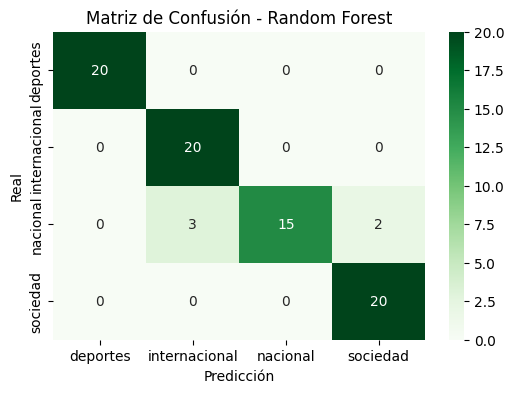

Número de fallos en las predicciones: 5


,Titular,Cuerpo,Categoría,Predicho
229,Gobierno anuncia programa de becas internacion...,Se lanzó una iniciativa que ofrece becas compl...,nacional,sociedad
296,Presidente anuncia iniciativa de apoyo a la ec...,Se presentó una estrategia que fomenta la reut...,nacional,sociedad
274,Presidente anuncia plan de modernización de la...,Se anunció una inversión de 90 mil millones de...,nacional,internacional
266,Presidente anuncia plan de apoyo a la industri...,Se lanzó un fondo de 50 mil millones de euros ...,nacional,internacional
225,Presidente anuncia medidas para la lucha contr...,El mandatario anunció nuevas políticas de audi...,nacional,internacional


In [34]:
# Preprocesamos los documentos del conjunto de test
test_documentos_procesados = []
for i, fila in test_df.iterrows():
    texto_combinado = f"{fila['Titular']} {fila['Cuerpo']}"
    tokens = preprocesar_documento(texto_combinado)
    test_documentos_procesados.append(" ".join(tokens))

print(f"Número de documentos de test procesados: {len(test_documentos_procesados)}")
print(f"Documentos procesados (muestra): {test_documentos_procesados[:3]}...")


# Predicciones con Random Forest
rf_predictions = random_forest_pipeline.predict(test_documentos_procesados)


# Métricas (macro, porque no es binario)
accuracy = accuracy_score(test_df['Categoría'], rf_predictions)
precision = precision_score(test_df['Categoría'], rf_predictions, average='macro')
recall = recall_score(test_df['Categoría'], rf_predictions, average='macro')
f1 = f1_score(test_df['Categoría'], rf_predictions, average='macro')

print("\nEvaluación del modelo Random Forest en el conjunto de test:")
print(f"Exactitud (Accuracy): {accuracy:.4f}")
print(f"Precisión (Precision - macro): {precision:.4f}")
print(f"Exhaustividad (Recall - macro): {recall:.4f}")
print(f"Puntuación F1 (F1 Score - macro): {f1:.4f}")

print("\nReporte de clasificación:")
print(classification_report(test_df['Categoría'], rf_predictions))

conf_matrix = confusion_matrix(test_df['Categoría'], rf_predictions)

etiquetas = random_forest_pipeline.named_steps['classifier'].classes_

plt.figure(figsize=(6, 4))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=etiquetas,
    yticklabels=etiquetas
)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Random Forest')
plt.show()

fallos = test_df[test_df['Categoría'] != rf_predictions]

print(f"Número de fallos en las predicciones: {len(fallos)}")

fallos = fallos.assign(Predicho = rf_predictions[test_df['Categoría'] != rf_predictions])

display(fallos[['Titular','Cuerpo','Categoría','Predicho']])


In [35]:
# Configuramos el cross validator estratificado
cross_validator = StratifiedKFold(
    n_splits=15,                # Número de folds
    shuffle=True,               # Mezcla aleatoria
    random_state=RANDOM_SEED    # Reproducibilidad
)

# Realiza la validación cruzada sobre Random Forest
scores = cross_val_score(
    estimator=random_forest_pipeline,
    X=train_documentos_procesados,
    y=train_df['Categoría'],    
    cv=cross_validator,
    scoring='accuracy'
)

# Muestra los resultados de la validación cruzada
print("Resultados de la validación cruzada (accuracy) en el conjunto de entrenamiento:")
for fold_idx, score in enumerate(scores):
    print(f" Fold {fold_idx + 1}: {score:.4f}")

print(f" Precisión media: {scores.mean():.4f} ± {scores.std():.4f}")


Resultados de la validación cruzada (accuracy) en el conjunto de entrenamiento:
 Fold 1: 0.9545
 Fold 2: 0.9545
 Fold 3: 0.9091
 Fold 4: 0.9545
 Fold 5: 0.9091
 Fold 6: 0.9048
 Fold 7: 0.9048
 Fold 8: 0.9048
 Fold 9: 1.0000
 Fold 10: 0.9524
 Fold 11: 1.0000
 Fold 12: 0.9048
 Fold 13: 1.0000
 Fold 14: 0.9524
 Fold 15: 1.0000
 Precisión media: 0.9470 ± 0.0378


In [36]:
# Especificamos los HiperParámetros a evaluar en el GridSearchCV
random_forest_param_grid = {
    # Hiper-Parámetros del RandomForest
    'classifier__n_estimators': [100, 300, 700, 800, 900, 1000],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [20, 50, 100, 150, 200, 250]
}

cv = StratifiedKFold(n_splits=15, shuffle=True, random_state=RANDOM_SEED)

# Configurar GridSearchCV
random_forest_grid = GridSearchCV(
    estimator=random_forest_pipeline,
    param_grid=random_forest_param_grid,
    cv=10,                  # validación cruzada interna
    scoring='accuracy',
    n_jobs=-1,
    refit=True,
    verbose=5
)

# Ejecuta el ajuste del modelo con el GridSearchCV
start_time = pd.Timestamp.now()
random_forest_grid.fit(
    train_documentos_procesados,
    train_df['Categoría']    
)
end_time = pd.Timestamp.now()

print(f"Tiempo de ejecución del GridSearchCV: {(end_time - start_time).total_seconds()} segundos")


# Mostrar los mejores hiper-parámetros encontrados
print("Mejores hiper-parámetros encontrados:")
best_parms = pd.Series(random_forest_grid.best_params_)
display(best_parms)

print(f"Mejor puntuación de validación cruzada: {random_forest_grid.best_score_:.4f}")


Fitting 10 folds for each of 72 candidates, totalling 720 fits
Tiempo de ejecución del GridSearchCV: 142.734397 segundos
Mejores hiper-parámetros encontrados:


classifier__criterion       entropy
classifier__max_depth            20
classifier__n_estimators        300
dtype: object

Mejor puntuación de validación cruzada: 0.9500



Resultados completos del Grid Search:

Evaluación del mejor modelo en el conjunto de test:
Exactitud (Accuracy): 0.9500
Macro Average - Precision: 0.9535, Recall: 0.9500, F1-score: 0.9495
Micro Average - Precision: 0.9500, Recall: 0.9500, F1-score: 0.9500
Weighted Average - Precision: 0.9535, Recall: 0.9500, F1-score: 0.9495

Reporte de clasificación del mejor modelo:
               precision    recall  f1-score   support

     deportes     1.0000    1.0000    1.0000        20
internacional     0.9048    0.9500    0.9268        20
     nacional     1.0000    0.8500    0.9189        20
     sociedad     0.9091    1.0000    0.9524        20

     accuracy                         0.9500        80
    macro avg     0.9535    0.9500    0.9495        80
 weighted avg     0.9535    0.9500    0.9495        80



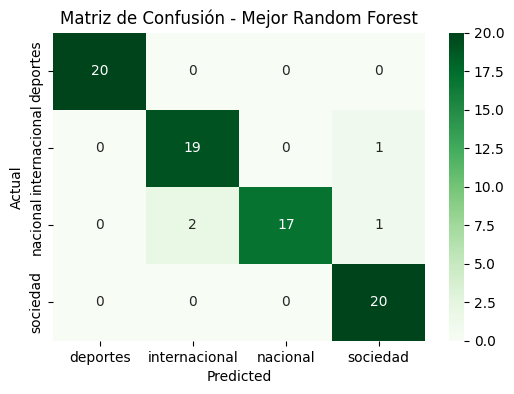

Número de fallos en las predicciones: 4


,Titular,Cuerpo,Categoría,Predicción,Predicción_TFIDF,predicted
116,Acuerdo de paz en Colombia firmado con grupos ...,El nuevo acuerdo incluye la desmovilización de...,internacional,internacional,internacional,sociedad
229,Gobierno anuncia programa de becas internacion...,Se lanzó una iniciativa que ofrece becas compl...,nacional,nacional,sociedad,sociedad
274,Presidente anuncia plan de modernización de la...,Se anunció una inversión de 90 mil millones de...,nacional,nacional,nacional,internacional
225,Presidente anuncia medidas para la lucha contr...,El mandatario anunció nuevas políticas de audi...,nacional,internacional,internacional,internacional


In [37]:
print("\nResultados completos del Grid Search:")

# Nos quedamos con el mejor modelo encontrado
best_random_forest_model = random_forest_grid.best_estimator_

# Entrenamos el mejor modelo con todo el conjunto de entrenamiento
best_random_forest_model.fit(
    train_documentos_procesados,
    train_df['Categoría']    
)

# Ejecutamos todas las predicciones sobre el conjunto de test.
best_random_forest_predictions = best_random_forest_model.predict(test_documentos_procesados)

# Evaluamos el rendimiento del mejor modelo encontrado
best_accuracy = accuracy_score(test_df['Categoría'], best_random_forest_predictions)

# Para precisión, recall y F1 usamos PROMEDIOS, porque NO hay clase 'spam'
best_precision_macro = precision_score(test_df['Categoría'], best_random_forest_predictions, average='macro', zero_division=0)
best_recall_macro = recall_score(test_df['Categoría'], best_random_forest_predictions, average='macro', zero_division=0)
best_f1_macro = f1_score(test_df['Categoría'], best_random_forest_predictions, average='macro', zero_division=0)

best_precision_micro = precision_score(test_df['Categoría'], best_random_forest_predictions, average='micro', zero_division=0)
best_recall_micro = recall_score(test_df['Categoría'], best_random_forest_predictions, average='micro', zero_division=0)
best_f1_micro = f1_score(test_df['Categoría'], best_random_forest_predictions, average='micro', zero_division=0)

best_precision_weighted = precision_score(test_df['Categoría'], best_random_forest_predictions, average='weighted', zero_division=0)
best_recall_weighted = recall_score(test_df['Categoría'], best_random_forest_predictions, average='weighted', zero_division=0)
best_f1_weighted = f1_score(test_df['Categoría'], best_random_forest_predictions, average='weighted', zero_division=0)

print("\nEvaluación del mejor modelo en el conjunto de test:")
print(f"Exactitud (Accuracy): {best_accuracy:.4f}")
print(f"Macro Average - Precision: {best_precision_macro:.4f}, Recall: {best_recall_macro:.4f}, F1-score: {best_f1_macro:.4f}")
print(f"Micro Average - Precision: {best_precision_micro:.4f}, Recall: {best_recall_micro:.4f}, F1-score: {best_f1_micro:.4f}")
print(f"Weighted Average - Precision: {best_precision_weighted:.4f}, Recall: {best_recall_weighted:.4f}, F1-score: {best_f1_weighted:.4f}")

print("\nReporte de clasificación del mejor modelo:")
print(classification_report(test_df['Categoría'], best_random_forest_predictions, digits=4))

# Muestra la matriz de confusión del mejor modelo
best_conf_matrix = confusion_matrix(test_df['Categoría'], best_random_forest_predictions)

plt.figure(figsize=(6, 4))
sns.heatmap(
    best_conf_matrix,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=best_random_forest_model.classes_,
    yticklabels=best_random_forest_model.classes_
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión - Mejor Random Forest')
plt.show()

# Muestra los documentos mal clasificados
fallos = test_df[test_df['Categoría'] != best_random_forest_predictions]
print(f"Número de fallos en las predicciones: {fallos.shape[0]}")
display(fallos.assign(predicted = best_random_forest_predictions[test_df['Categoría'] != best_random_forest_predictions]))


# SVM para clasificación de noticias periodísticas

In [ ]:
# Crea el vectorizador TF-IDF
tfidf_vectorizer = TfidfVectorizer(
    stop_words=None,                # Ya hemos preprocesado los documentos y eliminado stopwords.
    ngram_range=(1,1),              # Unigramas.
    analyzer='word',                # Palabras.
    max_df=0.5,                     # Ignora términos muy frecuentes.
    min_df=1,                       # Términos que aparezcan al menos 1 vez.
    max_features=None               # Sin límite de vocabulario.
)

linear_svc = LinearSVC(
    loss='hinge',                   # Función de pérdida SVM lineal.
    C=1.0,                          # Regularización.
    max_iter=1000,                  # Iteraciones máximas.
    tol=1e-4,                       # Tolerancia.
    random_state=RANDOM_SEED        # Semilla.
)

linearsvc_pipeline = Pipeline(
    steps=[
        ('vectorizer', tfidf_vectorizer),
        ('classifier', linear_svc)
    ]
)

# ENTRENAMIENTO con tu columna correcta: 'Categoría'
linearsvc_pipeline.fit(
    train_documentos_procesados,
    train_df['Categoría']           
)


Pipeline(steps=[('vectorizer', TfidfVectorizer(max_df=0.5)),
                ('classifier', LinearSVC(loss='hinge', random_state=202510))])

Número de documentos de test procesados: 80
Documentos de test procesados: ['influencia política igualdad salarial retención laboral ajuste salario reducido rotación personal femenino mejorar estabilidad productividad empresa privado', 'real madrid vence barcelona final laligar partido lleno emoción real madrid lograr victoria contundente rival histórico barcelona gol llegar largo encuentro vinícius júnior abrir marcador tiro libre magistral luego karim benzemo sellar ventaja segundo tiempo finalmente rodrygo añadir gol dejar público enloquecido', 'presidente méxico proponer reforma fiscal impulsar economía plan incluir reducción impuesto pym nuevo regulación grande conglomerado']...

Evaluación del modelo SVM (LinearSVC) en el conjunto de test:
Exactitud (Accuracy): 0.9375
Precisión (Precision): 0.9403
Exhaustividad (Recall): 0.9375
Puntuación F1 (F1 Score): 0.9370

Reporte de clasificación:
               precision    recall  f1-score   support

     deportes       1.00      1.00    

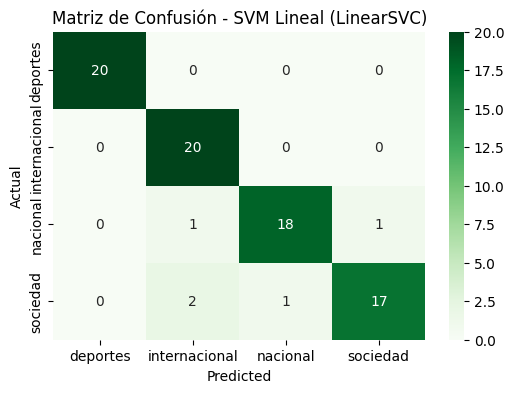

Número de fallos en las predicciones: 5


,Titular,Cuerpo,Categoría,Predicción,Predicción_TFIDF,predicted
350,La influencia de las políticas de igualdad sal...,Los ajustes en los salarios han reducido la ro...,sociedad,sociedad,nacional,nacional
382,El impacto del cambio climático en la disponib...,Las sequías prolongadas están alterando la ges...,sociedad,internacional,internacional,internacional
229,Gobierno anuncia programa de becas internacion...,Se lanzó una iniciativa que ofrece becas compl...,nacional,nacional,sociedad,sociedad
225,Presidente anuncia medidas para la lucha contr...,El mandatario anunció nuevas políticas de audi...,nacional,internacional,internacional,internacional
398,El impacto del cambio climático en la disponib...,Las sequías prolongadas están alterando la ges...,sociedad,internacional,internacional,internacional


In [69]:
# Preprocesamos los documentos del conjunto de test
test_documentos_procesados = []
for i, fila in test_df.iterrows():
    texto_combinado = f"{fila['Titular']} {fila['Cuerpo']}"
    tokens = preprocesar_documento(texto_combinado)
    test_documentos_procesados.append(" ".join(tokens))

# Número de documentos de test procesados
print(f"Número de documentos de test procesados: {len(test_documentos_procesados)}")
print(f"Documentos de test procesados: {test_documentos_procesados[:3]}...")

# Realiza las predicciones utilizando el pipeline entrenado
predicciones = linearsvc_pipeline.predict(test_documentos_procesados)

# Evalúa el rendimiento del modelo
accuracy = accuracy_score(test_df['Categoría'], predicciones)
precision = precision_score(test_df['Categoría'], predicciones, average='macro', zero_division=0)
recall = recall_score(test_df['Categoría'], predicciones, average='macro', zero_division=0)
f1 = f1_score(test_df['Categoría'], predicciones, average='macro', zero_division=0)

print("\nEvaluación del modelo SVM (LinearSVC) en el conjunto de test:")
print(f"Exactitud (Accuracy): {accuracy:.4f}")
print(f"Precisión (Precision): {precision:.4f}")
print(f"Exhaustividad (Recall): {recall:.4f}")
print(f"Puntuación F1 (F1 Score): {f1:.4f}")

print("\nReporte de clasificación:")
print(classification_report(test_df['Categoría'], predicciones, zero_division=0))

# Matriz de confusión
conf_matrix = confusion_matrix(test_df['Categoría'], predicciones)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens',
            xticklabels=linearsvc_pipeline.classes_,
            yticklabels=linearsvc_pipeline.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión - SVM Lineal (LinearSVC)')
plt.show()

# Documentos mal clasificados
fallos = test_df[test_df['Categoría'] != predicciones]
print(f"Número de fallos en las predicciones: {fallos.shape[0]}")
display(fallos.assign(predicted=predicciones[test_df['Categoría'] != predicciones]))


In [ ]:
# Configuramos el cross validator estratificado
cross_validator = StratifiedKFold(
    n_splits=10,                    # Número de folds
    shuffle=True,                   # Mezcla los datos antes de dividir
    random_state=RANDOM_SEED        # Semilla para reproducibilidad
)

# Realiza la validación cruzada...
scores = cross_val_score(
    estimator=linearsvc_pipeline,   # Pipeline con LinearSVC
    X=train_documentos_procesados,  # Documentos de entrenamiento preprocesados
    y=train_df['Categoría'],        
    cv=cross_validator,             # Validador cruzado estratificado
    scoring='accuracy'              # Métrica de evaluación
)

# Muestra los resultados de la validación cruzada
print("Resultados de la validación cruzada (accuracy) en el conjunto de entrenamiento:")
for fold_idx, score in enumerate(scores):
    print(f" Fold {fold_idx + 1}: {score:.4f}")

print(f" Exactitud media: {scores.mean():.4f} ± {scores.std():.4f}")


Resultados de la validación cruzada (accuracy) en el conjunto de entrenamiento:
 Fold 1: 1.0000
 Fold 2: 0.9688
 Fold 3: 0.9688
 Fold 4: 0.9688
 Fold 5: 0.9375
 Fold 6: 1.0000
 Fold 7: 0.9688
 Fold 8: 0.9688
 Fold 9: 0.9375
 Fold 10: 1.0000
 Exactitud media: 0.9719 ± 0.0219


In [ ]:
# Especificamos los Hiper-Parámetros a evaluar en el GridSearchCV
linearsvc_param_grid = {
    'classifier__loss': ['hinge', 'squared_hinge'],
    'classifier__C': [0.01, 0.02, 0.1, 0.2, 0.3, 0.4, 0.5, 1],
    'classifier__tol': [1e-4, 1e-3, 1e-2],
    'classifier__max_iter': [1000, 2000, 5000, 10000]
}

# Configurar GridSearchCV
linearsvc_grid = GridSearchCV(
    estimator=linearsvc_pipeline,       # Pipeline con LinearSVC
    param_grid=linearsvc_param_grid,    # Hiperparámetros a ajustar
    cv=10,                              # Validación cruzada interna
    scoring='accuracy',                 # Métrica de evaluación
    n_jobs=-1,                          # Todos los cores
    refit=True,                         # Reentrena con los mejores hiperparámetros
    verbose=5
)

# Ejecuta el ajuste del modelo con el GridSearchCV
start_time = pd.Timestamp.now()
linearsvc_grid.fit(
    train_documentos_procesados,
    train_df['Categoría']              
)
end_time = pd.Timestamp.now()

print(f"Tiempo de ejecución del GridSearchCV: {(end_time - start_time).total_seconds()} segundos")

# Mejores modelos
print("Mejores hiper-parámetros encontrados:")
best_parms = pd.Series(linearsvc_grid.best_params_)
display(best_parms)

print(f"Mejor puntuación de validación cruzada: {linearsvc_grid.best_score_:.4f}")


Fitting 10 folds for each of 192 candidates, totalling 1920 fits
Tiempo de ejecución del GridSearchCV: 11.732251 segundos
Mejores hiper-parámetros encontrados:


classifier__C                1
classifier__loss         hinge
classifier__max_iter      1000
classifier__tol         0.0001
dtype: object

Mejor puntuación de validación cruzada: 0.9719



Resultados completos del Grid Search:

Evaluación del mejor modelo SVM Lineal en el conjunto de test:
Exactitud (Accuracy): 0.9375
Precisión (Precision): 0.9403
Exhaustividad (Recall): 0.9375
Puntuación F1 (F1 Score): 0.9370

Reporte de clasificación del mejor modelo:
               precision    recall  f1-score   support

     deportes       1.00      1.00      1.00        20
internacional       0.87      1.00      0.93        20
     nacional       0.95      0.90      0.92        20
     sociedad       0.94      0.85      0.89        20

     accuracy                           0.94        80
    macro avg       0.94      0.94      0.94        80
 weighted avg       0.94      0.94      0.94        80



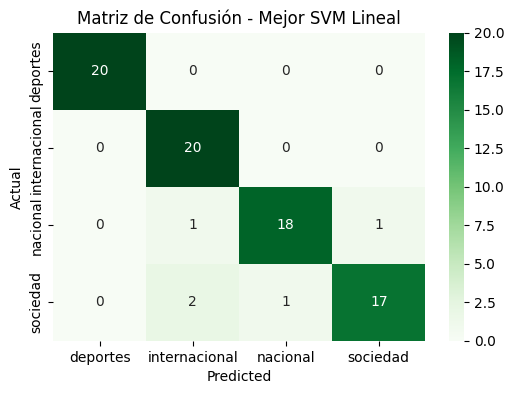

In [72]:
print("\nResultados completos del Grid Search:")

# Nos quedamos con el mejor modelo encontrado
best_linear_svc_model = linearsvc_grid.best_estimator_

# Ejecutamos las predicciones con el mejor modelo encontrado
best_linearsvc_predictions = best_linear_svc_model.predict(test_documentos_procesados)

# Evaluamos el rendimiento del mejor modelo encontrado (multiclase)
best_accuracy = accuracy_score(test_df['Categoría'], best_linearsvc_predictions)
best_precision = precision_score(test_df['Categoría'], best_linearsvc_predictions, average='macro', zero_division=0)
best_recall = recall_score(test_df['Categoría'], best_linearsvc_predictions, average='macro', zero_division=0)
best_f1 = f1_score(test_df['Categoría'], best_linearsvc_predictions, average='macro', zero_division=0)

print("\nEvaluación del mejor modelo SVM Lineal en el conjunto de test:")
print(f"Exactitud (Accuracy): {best_accuracy:.4f}")
print(f"Precisión (Precision): {best_precision:.4f}")
print(f"Exhaustividad (Recall): {best_recall:.4f}")
print(f"Puntuación F1 (F1 Score): {best_f1:.4f}")

print("\nReporte de clasificación del mejor modelo:")
print(classification_report(test_df['Categoría'], best_linearsvc_predictions, zero_division=0))

# Muestra la matriz de confusión del mejor modelo
best_conf_matrix = confusion_matrix(test_df['Categoría'], best_linearsvc_predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(best_conf_matrix, annot=True, fmt='d', cmap='Greens',
            xticklabels=best_linear_svc_model.classes_,
            yticklabels=best_linear_svc_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión - Mejor SVM Lineal')
plt.show()


# Regresión logística para clasificación de noticias periodísticas

In [16]:
# Configuración del modelo de Regresión Logística
logreg_model = LogisticRegression(
    solver='saga',              # Algoritmo de optimización
    penalty='elasticnet',       # Combinación de L1 y L2
    l1_ratio=0.5,               # Proporción de L1 (1.0 = Lasso, 0.0 = Ridge)
    C=1.0,                      # Fuerza de regularización
    class_weight=None,          # Manejo del desbalanceo
    max_iter=1000,              # Máximo de iteraciones
    tol=1e-4,                   # Tolerancia de convergencia
    random_state=RANDOM_SEED
)

# Pipeline con TF-IDF + Regresión Logística
logreg_pipeline = Pipeline(
    steps=[
        ('tfidf', tfidf_vectorizer),
        ('clf', logreg_model)
    ]
)

# Entrenamiento del modelo
logreg_pipeline.fit(
    train_documentos_procesados,
    train_df['Categoría']     
)


Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.5)),
                ('clf',
                 LogisticRegression(l1_ratio=0.5, max_iter=1000,
                                    penalty='elasticnet', random_state=202510,
                                    solver='saga'))])

In [17]:
# Guarda el pipeline completo en un archivo para su uso posterior
joblib.dump(logreg_pipeline, 'logreg_spam_pipeline.joblib')
print("Pipeline de Regresión Logística entrenado y guardado como 'logreg_spam_pipeline.joblib'")

Pipeline de Regresión Logística entrenado y guardado como 'logreg_spam_pipeline.joblib'


Número de documentos de test procesados: 80
Documentos de test procesados: ['influencia política igualdad salarial retención laboral ajuste salario reducido rotación personal femenino mejorar estabilidad productividad empresa privado', 'real madrid vence barcelona final laligar partido lleno emoción real madrid lograr victoria contundente rival histórico barcelona gol llegar largo encuentro vinícius júnior abrir marcador tiro libre magistral luego karim benzemo sellar ventaja segundo tiempo finalmente rodrygo añadir gol dejar público enloquecido', 'presidente méxico proponer reforma fiscal impulsar economía plan incluir reducción impuesto pym nuevo regulación grande conglomerado']...
Pipeline cargado correctamente.

Evaluación del modelo de Regresión Logística en el conjunto de test:
Exactitud (Accuracy): 0.9250
Precisión (Precision - macro): 0.9360
Exhaustividad (Recall - macro): 0.9250
Puntuación F1 (F1 Score - macro): 0.9241

Reporte de clasificación:
               precision    rec

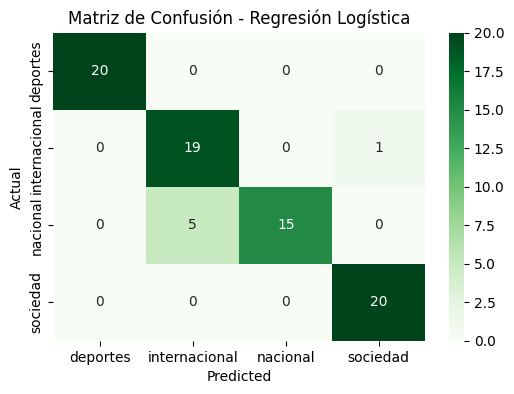

Número de fallos en las predicciones: 6


,Titular,Cuerpo,Categoría,longitud_titular,longitud_cuerpo,texto_completo,predicted
116,Acuerdo de paz en Colombia firmado con grupos ...,El nuevo acuerdo incluye la desmovilización de...,internacional,9,19,Acuerdo de paz en Colombia firmado con grupos ...,sociedad
229,Gobierno anuncia programa de becas internacion...,Se lanzó una iniciativa que ofrece becas compl...,nacional,6,31,Gobierno anuncia programa de becas internacion...,internacional
221,Gobierno anuncia plan de vivienda asequible,Se lanzó una iniciativa estatal para construir...,nacional,6,35,Gobierno anuncia plan de vivienda asequible Se...,internacional
274,Presidente anuncia plan de modernización de la...,Se anunció una inversión de 90 mil millones de...,nacional,10,27,Presidente anuncia plan de modernización de la...,internacional
225,Presidente anuncia medidas para la lucha contr...,El mandatario anunció nuevas políticas de audi...,nacional,9,25,Presidente anuncia medidas para la lucha contr...,internacional
287,Gobierno presenta plan de fomento al emprendim...,El gobierno anunció un programa de apoyo finan...,nacional,8,35,Gobierno presenta plan de fomento al emprendim...,internacional


In [18]:
# Preprocesamos los documentos del conjunto de test
test_documentos_procesados = []
for i, fila in test_df.iterrows():
    texto_combinado = f"{fila['Titular']} {fila['Cuerpo']}"
    tokens = preprocesar_documento(texto_combinado)
    test_documentos_procesados.append(" ".join(tokens))

# Número de documentos de test procesados
print(f"Número de documentos de test procesados: {len(test_documentos_procesados)}")
print(f"Documentos de test procesados: {test_documentos_procesados[:3]}...")


# Carga el pipeline guardado desde el archivo
logreg_loaded_pipeline = joblib.load('logreg_spam_pipeline.joblib')
print("Pipeline cargado correctamente.")


# Predicciones
predicciones = logreg_loaded_pipeline.predict(test_documentos_procesados)


# Métricas de evaluación
accuracy = accuracy_score(test_df['Categoría'], predicciones)
precision = precision_score(test_df['Categoría'], predicciones, average='macro')   
recall = recall_score(test_df['Categoría'], predicciones, average='macro')         
f1 = f1_score(test_df['Categoría'], predicciones, average='macro')                 

print("\nEvaluación del modelo de Regresión Logística en el conjunto de test:")
print(f"Exactitud (Accuracy): {accuracy:.4f}")
print(f"Precisión (Precision - macro): {precision:.4f}")
print(f"Exhaustividad (Recall - macro): {recall:.4f}")
print(f"Puntuación F1 (F1 Score - macro): {f1:.4f}")

print("\nReporte de clasificación:")
print(classification_report(test_df['Categoría'], predicciones))

# Muestra la matriz de confusión
conf_matrix = confusion_matrix(test_df['Categoría'], predicciones)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', 
            xticklabels= logreg_loaded_pipeline.classes_,
            yticklabels= logreg_loaded_pipeline.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión - Regresión Logística')
plt.show()

# Saca los documentos que han fallado y la etiqueta real y la predicha
fallos = test_df[test_df['Categoría'] != predicciones]
print(f"Número de fallos en las predicciones: {fallos.shape[0]}")
display(fallos.assign(predicted= predicciones[test_df['Categoría'] != predicciones]))

In [51]:
# Configuramos el cross validator estratificado
cross_validator = StratifiedKFold(
    n_splits=10,                  # Número de folds
    shuffle=True,                 # Mezclar los datos
    random_state=RANDOM_SEED      # Reproducibilidad
)

# Realiza la validación cruzada
scores = cross_val_score(
    estimator=logreg_pipeline,           # Pipeline RL
    X=train_documentos_procesados,       # Documentos ya preprocesados
    y=train_df['Categoría'],             
    cv=cross_validator,
    scoring='accuracy'
)

# Muestra resultados
print("Resultados de la validación cruzada (accuracy) en el conjunto de entrenamiento:")
for fold_idx, score in enumerate(scores):
    print(f" Fold {fold_idx + 1}: {score:.4f}")

print(f" Precisión media: {scores.mean():.4f} ± {scores.std():.4f}")


Resultados de la validación cruzada (accuracy) en el conjunto de entrenamiento:
 Fold 1: 0.9688
 Fold 2: 0.8750
 Fold 3: 0.9375
 Fold 4: 0.9062
 Fold 5: 0.8750
 Fold 6: 0.9375
 Fold 7: 0.9375
 Fold 8: 0.9062
 Fold 9: 0.9688
 Fold 10: 1.0000
 Precisión media: 0.9313 ± 0.0390


In [ ]:
# Especificamos los hiper parámetros a ajustar en el GridSearchCV
param_grid_1 = {
    'clf__C': [0.01, 0.1, 1, 10, 100],
    'clf__tol': [1e-4, 1e-3, 1e-2],
    'clf__max_iter': [1000, 2000, 5000, 10000]
}

param_grid_2 = {
    'tfidf__max_features': [500, 1000, 1271],
    'tfidf__ngram_range': [(1,1), (1,2), (1,3)],
    'clf__l1_ratio': [0.1, 0.5, 0.9],
    'clf__C': [0.01, 0.1, 1, 10, 100],
    'clf__tol': [1e-4, 1e-3, 1e-2],
    'clf__max_iter': [1000, 2000, 5000, 10000]
}

# Configurar GridSearchCV
logreg_grid = GridSearchCV(
    estimator=logreg_pipeline, 
    param_grid=param_grid_2,
    cv=10,
    scoring='accuracy',
    n_jobs=-1,
    refit=True,
    verbose=2
)

# Ejecuta el ajuste del modelo con el GridSearchCV
start_time = pd.Timestamp.now()
logreg_grid.fit(
    train_documentos_procesados,
    train_df['Categoría']     
)
end_time = pd.Timestamp.now()

print(f"Tiempo de ejecución del GridSearchCV: {(end_time - start_time).total_seconds()} segundos")

print("Mejores hiper-parámetros encontrados:")
best_parms = pd.Series(logreg_grid.best_params_)
display(best_parms)

print(f"Mejor puntuación de validación cruzada: {logreg_grid.best_score_:.4f}")


Fitting 10 folds for each of 1620 candidates, totalling 16200 fits
Tiempo de ejecución del GridSearchCV: 471.990543 segundos
Mejores hiper-parámetros encontrados:


clf__C                    100
clf__l1_ratio             0.1
clf__max_iter            1000
clf__tol                 0.01
tfidf__max_features      1000
tfidf__ngram_range     (1, 1)
dtype: object

Mejor puntuación de validación cruzada: 0.9688



Resultados completos del Grid Search:

Evaluación del mejor modelo de Regresión Logística en el conjunto de test:
Exactitud (Accuracy): 0.9375
Precisión (Precision - macro): 0.9452
Exhaustividad (Recall - macro): 0.9375
Puntuación F1 (F1 Score - macro): 0.9378

Reporte de clasificación del mejor modelo:
               precision    recall  f1-score   support

     deportes       1.00      1.00      1.00        20
internacional       0.83      1.00      0.91        20
     nacional       1.00      0.85      0.92        20
     sociedad       0.95      0.90      0.92        20

     accuracy                           0.94        80
    macro avg       0.95      0.94      0.94        80
 weighted avg       0.95      0.94      0.94        80



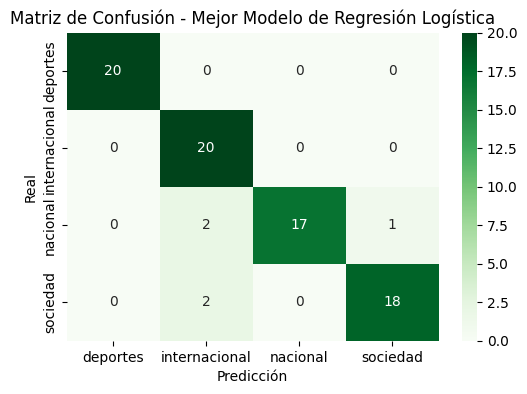

In [55]:
print("\nResultados completos del Grid Search:")

# Nos quedamos con el mejor modelo encontrado
best_logreg_model = logreg_grid.best_estimator_

# Ejecutamos las predicciones con el mejor modelo encontrado
best_logreg_predictions = best_logreg_model.predict(test_documentos_procesados)

# Evaluamos el rendimiento del mejor modelo encontrado
best_accuracy = accuracy_score(test_df['Categoría'], best_logreg_predictions)
best_precision = precision_score(test_df['Categoría'], best_logreg_predictions, average='macro')
best_recall = recall_score(test_df['Categoría'], best_logreg_predictions, average='macro')
best_f1 = f1_score(test_df['Categoría'], best_logreg_predictions, average='macro')

print("\nEvaluación del mejor modelo de Regresión Logística en el conjunto de test:")
print(f"Exactitud (Accuracy): {best_accuracy:.4f}")
print(f"Precisión (Precision - macro): {best_precision:.4f}")
print(f"Exhaustividad (Recall - macro): {best_recall:.4f}")
print(f"Puntuación F1 (F1 Score - macro): {best_f1:.4f}")

print("\nReporte de clasificación del mejor modelo:")
print(classification_report(test_df['Categoría'], best_logreg_predictions))

best_conf_matrix = confusion_matrix(test_df['Categoría'], best_logreg_predictions)

etiquetas = best_logreg_model.named_steps['clf'].classes_

plt.figure(figsize=(6, 4))
sns.heatmap(
    best_conf_matrix,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=etiquetas,
    yticklabels=etiquetas
)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Mejor Modelo de Regresión Logística')
plt.show()


# Conclusiones y análisis comparativo de los modelos

## Teoría sobre las métricas de evaluación usadas

Para evaluar el rendimiento de los distintos clasificadores se han utilizado métricas estándar de clasificación supervisada, tanto **por clase** como **agregadas**. 

#### 1. Matriz de confusión

La **matriz de confusión** resume el número de aciertos y errores del clasificador desglosados por clase.
En cada fila se representa la **clase real** y en cada columna la **clase predicha**:

* Los elementos de la **diagonal principal** (arriba–izquierda → abajo–derecha) son los **aciertos**.
* Los elementos fuera de la diagonal son las **confusiones**, es decir, ejemplos de una clase real que han sido clasificados como otra.

En problema multiclase como el de este trabajo (Deportes, Internacional, Nacional, Sociedad), la matriz de confusión permite ver **qué secciones se confunden entre sí**, más allá de una única cifra global de rendimiento.

---

#### 2. Exactitud (Accuracy)

La **exactitud** o *accuracy* es la proporción de ejemplos correctamente clasificados sobre el total:

$$
[
\text{Accuracy} = \frac{\text{nº de aciertos}}{\text{nº total de ejemplos}}
]
$$

Mide el rendimiento global del modelo. Es fácil de interpretar, pero en presencia de **clases desbalanceadas** puede ser engañosa, porque un modelo que acierta casi siempre la clase mayoritaria puede tener una accuracy alta aunque falle mucho en las clases minoritarias. Por ello, se complementa con métricas por clase y promedios agregados (macro, micro, weighted).

---

#### 3. Precisión (Precision)

La **precisión** para una clase concreta responde a la pregunta:

> “De todas las noticias que el modelo ha predicho como ‘X’, ¿cuántas eran realmente de la sección ‘X’?”

Formalmente, para una clase (c):

$$
[
\text{Precision}_c = \frac{\text{TP}_c}{\text{TP}_c + \text{FP}_c}
]
$$

* **TP** (true positives): ejemplos correctamente predichos como (c).
* **FP** (false positives): ejemplos de otras clases que el modelo ha etiquetado incorrectamente como (c).

Una precisión alta indica que el modelo **se equivoca poco cuando afirma que una noticia pertenece a una determinada sección** (bajo número de falsos positivos).

---

#### 4. Exhaustividad o sensibilidad (Recall)

La **exhaustividad** (*recall*) para una clase concreta responde a:

> “De todas las noticias que realmente eran de la sección ‘X’, ¿cuántas ha sido capaz de detectar el modelo?”

Para una clase (c):

$$
[
\text{Recall}_c = \frac{\text{TP}_c}{\text{TP}_c + \text{FN}_c}
]
$$

* **FN** (false negatives): ejemplos de la clase (c) que el modelo ha clasificado como otra cosa.

Un recall alto indica que el modelo **no se deja muchas noticias de esa sección sin detectar** (bajo número de falsos negativos).

---

#### 5. Medida F1 (F1-score)

La **medida F1** combina precisión y recall en un único valor, mediante su media armónica:

$$
[
\text{F1}_c = 2 \cdot \frac{\text{Precision}_c \cdot \text{Recall}_c}{\text{Precision}_c + \text{Recall}_c}
]
$$

Para una clase concreta, un F1 alto significa que el modelo presenta **un buen equilibrio entre precisión y recall**: ni se equivoca demasiado cuando predice esa clase, ni se deja demasiados ejemplos sin detectar.

En clasificación multiclase, a partir de los F1 por clase se pueden calcular distintas versiones agregadas (macro, micro, weighted).

---

#### 6. Métricas por clase y métricas agregadas

En este trabajo se emplean métricas **por clase** (precision, recall, F1 para cada sección de noticias) y también métricas **agregadas** que resumen el rendimiento global del modelo.

* Las métricas por clase permiten analizar, por ejemplo, si el modelo funciona mejor en **Deportes** que en **Sociedad** o **Nacional**.
* Las métricas agregadas condensan esos resultados en uno o varios indicadores globales.

---

#### 7. Promedio macro (macro average)

El **promedio macro** calcula la métrica (precisión, recall o F1) por clase y luego hace la **media aritmética simple** de todas las clases:
$$

[
\text{Métrica macro} = \frac{1}{C} \sum_{c=1}^{C} \text{Métrica}_c
]
$$

donde (C) es el número de clases.

* Todas las clases pesan **lo mismo**, independientemente de cuántos ejemplos tengan.
* Es especialmente útil para saber si el modelo se comporta de manera **equilibrada entre clases**, incluyendo aquellas con menos ejemplos.

En este trabajo, el **F1-macro** se utiliza como métrica clave para comparar modelos, ya que el dataset presenta un ligero desbalance entre categorías.

---

#### 8. Promedio micro (micro average)

El **promedio micro** suma los **TP, FP y FN de todas las clases** y calcula la métrica como si se tratara de un único problema global:

$$
[
\text{Precision micro} = \frac{\sum_c \text{TP}_c}{\sum_c (\text{TP}_c + \text{FP}_c)}
]
$$

y análogamente para recall y F1.

En problemas de clasificación multiclase en los que cada ejemplo tiene una única etiqueta verdadera (como en este trabajo), el F1-micro coincide con la **accuracy**. Por tanto, el promedio micro refleja básicamente el **rendimiento global** del modelo sobre el conjunto de datos, sin distinguir el comportamiento entre clases.

---

#### 9. Promedio ponderado (weighted average)

El **promedio weighted** también calcula la métrica por clase, pero la media final se hace **ponderando por el número de ejemplos (soporte) de cada clase**:

$$
[
\text{Métrica weighted} = \sum_{c=1}^{C} w_c \cdot \text{Métrica}_c
\quad\text{donde}\quad
w_c = \frac{\text{nº de ejemplos de la clase } c}{\text{nº total de ejemplos}}
]
$$

* Las clases con más ejemplos pesan más en el resultado final.
* Es útil cuando hay **desbalance de clases**, ya que aproxima mejor el comportamiento del modelo sobre el conjunto de datos real.

En este problema, al no existir un desbalance extremo, los valores de F1-weighted y F1-macro son similares, lo que indica que el modelo mantiene un rendimiento alto tanto en las clases mayoritarias como en las minoritarias.



## Naive Bayes con representación por conteo (BoW)

El clasificador Naive Bayes Multinomial es un modelo probabilístico muy utilizado en clasificación de textos. Asume que las palabras de un documento son independientes entre sí y calcula la probabilidad de que un texto pertenezca a cada clase en función de las frecuencias de sus palabras.
En la versión por conteo (bag-of-words), cada documento se representa como un vector donde cada componente indica cuántas veces aparece cada palabra en ese texto. Este enfoque es muy sencillo y computacionalmente eficiente, por lo que suele emplearse como modelo base para tareas de clasificación de documentos.

### Concluciones NB por conteo

+----------------------------+------------------+----------+-------------+-------------+----------+-------------+-------------+----------+----------------+----------------+--------------+
| Modelo                     | Representación   | Accuracy | Prec. macro | Rec. macro  | F1-macro | Prec. micro | Rec. micro  | F1-micro | Prec. weighted | Rec. weighted  | F1-weighted  |
+----------------------------+------------------+----------+-------------+-------------+----------+-------------+-------------+----------+----------------+----------------+--------------+
| Naive Bayes (Multinomial)  | Conteo (BoW)     | 0.9625   | 0.9674      | 0.9625      | 0.9630   | 0.9625      | 0.9625      | 0.9625   | 0.9674         | 0.9625         | 0.9630       |
+----------------------------+------------------+----------+-------------+-------------+----------+-------------+-------------+----------+----------------+----------------+--------------+


El clasificador **Naive Bayes Multinomial** utilizando una representación por **conteo de palabras (bag-of-words)** obtiene un rendimiento muy elevado en el conjunto de test.
En concreto, alcanza una exactitud (accuracy) de 0,9625, con valores de precision macro = 0,9674, recall macro = 0,9625 y F1-macro = 0,9630.

El análisis por clase muestra que:

Deportes se clasifica perfectamente (precision, recall y F1 = 1,00).

Internacional presenta una precision algo menor (0,87), aunque con un recall perfecto (1,00), lo que indica que el modelo tiende a etiquetar algunas noticias de otras secciones como internacionales, pero prácticamente no deja escapar noticias que realmente son de Internacional.

Nacional y Sociedad muestran también valores de F1 muy altos (0,97 y 0,95 respectivamente), con ligeras pérdidas en el recall (0,95 para Nacional y 0,90 para Sociedad).

La matriz de confusión refleja que los errores del modelo se concentran en un número muy reducido de ejemplos (3 noticias mal clasificadas sobre 80). En concreto, se observan dos noticias de la categoría sociedad y una de nacional que son clasificadas como internacional. Esto sugiere que, cuando el modelo se equivoca, suele hacerlo entre secciones de contenido más abstracto o solapado (Nacional/Sociedad/Internacional), **mientras que la sección de Deportes, con un vocabulario más específico, apenas genera confusiones.**

## Naive Bayes con representación TF-IDF

En la variante Naive Bayes + TF-IDF, el modelo es el mismo (Naive Bayes Multinomial), pero en lugar de usar conteos brutos se utiliza una representación TF-IDF (Term Frequency–Inverse Document Frequency).
TF-IDF pondera cada palabra según su frecuencia en el documento (TF) y su rareza en el conjunto de textos (IDF), de forma que reciben más peso los términos que son característicos de una noticia y menos peso las palabras muy frecuentes y poco informativas. Esta combinación se utiliza para intentar mejorar la discriminación entre clases, aprovechando no solo qué palabras aparecen, sino también cuán relevantes son dentro del corpus.

### Conclusiones TF-IDF

+----------------------------+------------------+----------+-------------+-------------+----------+-------------+-------------+----------+----------------+----------------+--------------+
| Modelo                     | Representación   | Accuracy | Prec. macro | Rec. macro  | F1-macro | Prec. micro | Rec. micro  | F1-micro | Prec. weighted | Rec. weighted  | F1-weighted  |
+----------------------------+------------------+----------+-------------+-------------+----------+-------------+-------------+----------+----------------+----------------+--------------+
| Naive Bayes (Multinomial)  | Conteo (BoW)     | 0.9625   | 0.9674      | 0.9625      | 0.9630   | 0.9625      | 0.9625      | 0.9625   | 0.9674         | 0.9625         | 0.9630       |
| Naive Bayes (Multinomial)  | TF-IDF           | 0.9250   | 0.9306      | 0.9250      | 0.9246   | 0.9250      | 0.9250      | 0.9250   | 0.9306         | 0.9250         | 0.9246       |
+----------------------------+------------------+----------+-------------+-------------+----------+-------------+-------------+----------+----------------+----------------+--------------+


En segundo lugar se evaluó un clasificador **Naive Bayes Multinomial** utilizando una representación de los documentos mediante **TF-IDF**. En este caso, el modelo alcanza una exactitud (accuracy) de 0,9250, claramente inferior a la obtenida con la representación por conteo. Las métricas agregadas muestran un comportamiento coherente: precision macro = 0,9306, recall macro = 0,9250 y F1-macro = 0,9246, mientras que los valores de promedio micro y weighted coinciden prácticamente con estos, lo que indica un rendimiento global bueno, pero algo menos equilibrado que en el modelo anterior.

El análisis por clase revela que la sección de Deportes vuelve a clasificarse de forma perfecta (precision, recall y F1 = 1,00), lo que sugiere que el vocabulario deportivo está muy bien capturado por el modelo. Sin embargo, se observa un empeoramiento en las secciones de Nacional y Sociedad, que pasan de F1 ≈ 0,97 y 0,95 en el modelo por conteo a valores en torno a 0,89 en el modelo con TF-IDF. En estas clases, el recall desciende a 0,85, lo que indica que el modelo deja sin detectar una parte de las noticias que realmente pertenecen a dichas secciones. La categoría Internacional mantiene un recall perfecto (1,00), pero su precision baja hasta 0,83, lo que significa que el modelo tiende a etiquetar como internacionales algunas noticias que en realidad pertenecen a otras secciones (especialmente Nacional y Sociedad).

La matriz de confusión confirma estos resultados: no se observan errores en la clasificación de Deportes, pero aparecen varias confusiones cruzadas entre Nacional, Sociedad e Internacional. Noticias relacionadas con políticas internas o temas sociales se clasifican a veces como internacionales, y viceversa, lo que refleja la mayor dificultad del modelo para separar secciones cuyo vocabulario y temática son parcialmente solapados.

**En conjunto, aunque el uso de TF-IDF también proporciona resultados aceptables, en este problema concreto la representación basada en conteo de palabras parece ser más adecuada para Naive Bayes**, ofreciendo una mejor separación entre las secciones y métricas de F1-macro superiores. Esto sugiere que, al menos para este dataset, **la combinación de NB con TF-IDF no aporta una mejora frente al modelo NB por conteo**.

## Random Forest

Random Forest es un modelo de aprendizaje conjunto basado en muchos árboles de decisión. Cada árbol se entrena con una muestra distinta de los datos y con un subconjunto aleatorio de características; después, para clasificar una noticia, todos los árboles votan y se toma la clase más frecuente.
Sirve para capturar relaciones no lineales y combinaciones complejas de características, suele ser robusto al ruido y al sobreajuste, y proporciona un rendimiento sólido sin necesidad de mucho ajuste fino. En clasificación de texto se utiliza sobre todo cuando se quiere probar un modelo potente y relativamente interpretable sobre las representaciones TF-IDF.

### Conclusiones Random Forest

+----------------------------+------------------+----------+-------------+-------------+----------+-------------+-------------+----------+----------------+----------------+--------------+
| Modelo                     | Representación   | Accuracy | Prec. macro | Rec. macro  | F1-macro | Prec. micro | Rec. micro  | F1-micro | Prec. weighted | Rec. weighted  | F1-weighted  |
+----------------------------+------------------+----------+-------------+-------------+----------+-------------+-------------+----------+----------------+----------------+--------------+
| Random Forest (mejor)      | TF-IDF           | 0.9500   | 0.9535      | 0.9500      | 0.9495   | 0.9500      | 0.9500      | 0.9500   | 0.9535         | 0.9500         | 0.9495       |
+----------------------------+------------------+----------+-------------+-------------+----------+-------------+-------------+----------+----------------+----------------+--------------+


Para probar un modelo que combina muchos árboles de decisión, se entrenó un Random Forest sobre la representación TF-IDF de los documentos. El modelo básico obtuvo una accuracy de 0,9375, con métricas agregadas de precisión macro = 0,9447, recall macro = 0,9375 y F1-macro = 0,9349. A continuación se realizó una búsqueda de hiperparámetros mediante GridSearchCV, variando el número de árboles, la profundidad máxima y el criterio de división. El mejor modelo encontrado, con 300 árboles, profundidad máxima 20 y criterio entropy, alcanzó una exactitud del 0,9500 en el conjunto de test, junto con precisión macro = 0,9535, recall macro = 0,9500 y F1-macro = 0,9495. Los promedios micro y weighted ofrecen valores muy similares, lo que confirma un buen rendimiento global del clasificador.

El reporte de clasificación del mejor Random Forest muestra resultados excelentes en las cuatro secciones. La clase Deportes se clasifica de forma perfecta (precision, recall y F1 = 1,00), mientras que Internacional y Sociedad presentan F1 superiores a 0,92. La sección Nacional es la que concentra más errores (F1 ≈ 0,92), con noticias que a veces se confunden con Internacional o Sociedad. La matriz de confusión refleja precisamente estos fallos: los errores se concentran en ejemplos de Nacional que son etiquetados como Internacional o Sociedad, mientras que apenas se observan confusiones que involucren a Deportes.

Los resultados de la validación cruzada estratificada en el conjunto de entrenamiento (15 folds) muestran una precisión media de aproximadamente 0,947 ± 0,038, muy próxima a la exactitud obtenida en test con el mejor modelo (0,95). Esto sugiere que Random Forest generaliza bien y no presenta un sobreajuste marcado. En conjunto, Random Forest se comporta como un clasificador robusto y de alto rendimiento, aunque, como se verá en la comparación final, la SVM lineal y la regresión logística logran todavía un ligero incremento en F1-macro sobre la misma representación TF-IDF.

## SVM lineal (Support Vector Machine)

Las Máquinas de Vectores de Soporte (SVM) son modelos que buscan la frontera de separación entre clases que maximiza el margen entre los ejemplos de diferentes categorías. En el caso de una SVM lineal, esa frontera es un hiperplano en el espacio de características.
En clasificación de textos con TF-IDF, las SVM lineales funcionan especialmente bien porque son capaces de manejar espacios de muy alta dimensión (muchas palabras) y encontrar separaciones muy finas entre clases. Se utilizan cuando se busca un modelo con gran capacidad de generalización y muy buen rendimiento global.

### Conclusiones SVM lineal

+----------------------------+------------------+----------+-------------+-------------+----------+-------------+-------------+----------+----------------+----------------+--------------+
| Modelo                     | Representación   | Accuracy | Prec. macro | Rec. macro  | F1-macro | Prec. micro | Rec. micro  | F1-micro | Prec. weighted | Rec. weighted  | F1-weighted  |
+----------------------------+------------------+----------+-------------+-------------+----------+-------------+-------------+----------+----------------+----------------+--------------+
| SVM lineal (LinearSVC)     | TF-IDF           | 0.9375   | 0.9403      | 0.9375      | 0.9370   | 0.9375      | 0.9375      | 0.9375   | ≈0.94          | ≈0.94          | ≈0.94        |
+----------------------------+------------------+----------+-------------+-------------+----------+-------------+-------------+----------+----------------+----------------+--------------+


Para evaluar un modelo lineal discriminativo se entrenó una Máquina de Vectores de Soporte lineal (SVM lineal, LinearSVC) sobre la representación TF-IDF de los documentos, integrada en un pipeline con el vectorizador. El modelo básico, tras ajustar sus hiperparámetros mediante validación cruzada, obtuvo en el conjunto de test una exactitud (accuracy) de 0,9375, con una precisión macro de 0,9403, recall macro de 0,9375 y F1-macro de 0,9370. El promedio micro coincide con la accuracy y los valores weighted son también cercanos a 0,94, lo que indica un rendimiento global alto y relativamente equilibrado entre las distintas secciones.

El reporte de clasificación muestra que la sección de Deportes se clasifica de forma perfecta (precision, recall y F1 = 1,00), mientras que Internacional alcanza un F1 de 0,93 y las clases Nacional y Sociedad presentan F1 en torno a 0,92 y 0,89, respectivamente. La matriz de confusión refleja que la mayoría de los errores se concentran en confusiones entre Nacional y Sociedad, o bien en algunas noticias de Sociedad etiquetadas como Internacional, lo que es coherente con el solapamiento semántico entre estas secciones.

Los resultados de la validación cruzada estratificada sobre el conjunto de entrenamiento (10 folds) muestran una exactitud media de aproximadamente 0,972 ± 0,022, muy superior a 0,95 en la mayoría de los pliegues, lo que sugiere que la SVM lineal se adapta muy bien a la estructura del problema y presenta una buena capacidad de generalización. Aunque en este dataset concreto el mejor Random Forest llega a superar ligeramente su F1-macro, la SVM lineal sigue ofreciendo un rendimiento muy competitivo con una arquitectura relativamente sencilla y eficiente para espacios de alta dimensión como los generados por TF-IDF.

## Regresión logística

La Regresión Logística es un modelo lineal que estima, para cada clase, la probabilidad de que un documento pertenezca a esa categoría en función de sus características (por ejemplo, los pesos TF-IDF de sus palabras). Aunque originalmente se diseñó para problemas binarios, puede extenderse fácilmente a la clasificación multiclase.
Sirve como modelo base muy potente en PLN: es relativamente sencillo, rápido de entrenar, pero a la vez expresivo cuando se combina con buenas representaciones como TF-IDF. Suele ofrecer un excelente equilibrio entre interpretabilidad y rendimiento, y por eso es uno de los clasificadores de referencia para problemas de clasificación de textos.

### Conclusiones regresión logística

+----------------------------+------------------+----------+-------------+-------------+----------+-------------+-------------+----------+----------------+----------------+--------------+
| Modelo                     | Representación   | Accuracy | Prec. macro | Rec. macro  | F1-macro | Prec. micro | Rec. micro  | F1-micro | Prec. weighted | Rec. weighted  | F1-weighted  |
+----------------------------+------------------+----------+-------------+-------------+----------+-------------+-------------+----------+----------------+----------------+--------------+
| Regresión Logística (mejor)| TF-IDF           | 0.9375   | 0.9452      | 0.9375      | 0.9378   | 0.9375      | 0.9375      | 0.9375   | ≈0.95          | ≈0.94          | ≈0.94        |
+----------------------------+------------------+----------+-------------+-------------+----------+-------------+-------------+----------+----------------+----------------+--------------+


Finalmente, se entrenó un modelo de Regresión Logística multiclase sobre la representación TF-IDF de los documentos, integrando tanto el vectorizador como el clasificador en un mismo pipeline y ajustando los hiperparámetros mediante GridSearchCV. El mejor modelo encontrado, con una regularización relativamente baja (C = 100), un término de mezcla L1/L2 (l1_ratio = 0,1) y un vocabulario TF-IDF limitado a 1000 características, alcanzó en el conjunto de test una exactitud (accuracy) de 0,9375, con precisión macro = 0,9452, recall macro = 0,9375 y F1-macro = 0,9378. Los promedios micro y weighted presentan valores muy similares (≈ 0,94), lo que indica un rendimiento global alto y bastante equilibrado entre las distintas secciones.

El reporte de clasificación del mejor modelo muestra un comportamiento excelente en la clase Deportes, que se clasifica de forma perfecta (precision, recall y F1 = 1,00), y muy bueno en Sociedad (F1 ≈ 0,92). Las secciones Internacional y Nacional presentan F1 en torno a 0,91–0,92: Internacional tiende a tener una ligera pérdida de precisión (predice algunas noticias de otras secciones como internacionales), mientras que Nacional muestra un recall algo inferior (parte de sus noticias se confunden con Internacional o Sociedad). Estos patrones se reflejan claramente en la matriz de confusión, donde la mayoría de los errores se concentran en confusiones entre Nacional, Internacional y Sociedad, mientras que Deportes prácticamente no se ve afectada.

En la validación cruzada estratificada (10 folds) sobre el conjunto de entrenamiento, la Regresión Logística alcanza una exactitud media aproximada de 0,93 ± 0,04, con una mejor puntuación de validación de 0,9688 en algunos pliegues, lo que sugiere una buena capacidad de generalización y una estabilidad razonable del modelo. En conjunto, la Regresión Logística se comporta como un clasificador lineal robusto y competitivo sobre TF-IDF, con un rendimiento muy cercano al de la SVM lineal y ligeramente inferior, en este dataset concreto, al mejor Random Forest.

## Conclusiones finales

| Modelo                      | Representación | Accuracy | Prec. macro | Rec. macro | F1-macro |
|-----------------------------|----------------|----------|-------------|------------|----------|
| Naive Bayes (Multinomial)   | Conteo (BoW)   | 0.9625   | 0.9674      | 0.9625     | 0.9630   |
| Random Forest               | TF-IDF         | 0.9500   | 0.9535      | 0.9500     | 0.9495   |
| Regresión Logística         | TF-IDF         | 0.9375   | 0.9452      | 0.9375     | 0.9378   |
| SVM lineal (LinearSVC)      | TF-IDF         | 0.9375   | 0.9403      | 0.9375     | 0.9370   |
| Naive Bayes (Multinomial)   | TF-IDF         | 0.9250   | 0.9306      | 0.9250     | 0.9246   |



### Comparación general de modelos

A la vista de la tabla, todos los clasificadores alcanzan un **rendimiento alto** en el conjunto de test (accuracy ≥ 0,92), pero se observan diferencias claras:

* El mejor resultado global lo obtiene **Naive Bayes Multinomial con representación por conteo (BoW)**, con una **accuracy de 0,9625** y un **F1-macro de 0,9630**.
* El segundo mejor modelo es **Random Forest con TF-IDF**, con **accuracy 0,95** y **F1-macro 0,9495**.
* **Regresión Logística** y **SVM lineal** muestran resultados muy similares entre sí, con **accuracy de 0,9375** y **F1-macro ≈ 0,94**.
* La combinación **Naive Bayes + TF-IDF** es la que rinde peor de las cinco, con **accuracy 0,9250** y **F1-macro ≈ 0,92**, aunque sigue siendo un modelo válido.

En términos de **F1-macro** (que da el mismo peso a cada clase y es la métrica más adecuada para este problema ligeramente desbalanceado), el ranking sería:

1. **NB (conteo)** – 0,9630
2. **Random Forest** – 0,9495
3. **Regresión Logística** – 0,9378
4. **SVM lineal** – 0,9370
5. **NB (TF-IDF)** – 0,9246

###  Influencia de la representación: conteo vs TF-IDF

Un resultado llamativo es que, para **Naive Bayes**, la representación **por conteo** funciona mejor que TF-IDF:

* NB por conteo: F1-macro = 0,9630
* NB por TF-IDF: F1-macro = 0,9246

Esto sugiere que, en este dataset concreto, el clasificador bayesiano se beneficia más de **frecuencias absolutas** que de los pesos normalizados de TF-IDF. Dado que NB es un modelo muy simple y asume independencia entre características, la transformación TF-IDF no le aporta una ventaja clara y puede incluso introducir ruido en sus probabilidades.

En cambio, los modelos **discriminativos** (Regresión Logística, SVM) y el **Random Forest** sí se adaptan bien a TF-IDF y sacan buen partido de esa representación, manteniendo F1-macro altos.

###  Patrones de error y matriz de confusión

En todos los modelos se observa un patrón común en las **matrices de confusión**:

* La sección **Deportes** se clasifica siempre de forma perfecta (precision, recall y F1 = 1,00 en todos los modelos), gracias a su vocabulario muy específico.
* **Internacional** también suele presentar **recall muy alto** (a veces 1,00), aunque con una precisión algo menor: algunas noticias de otras secciones (sobre todo Nacional o Sociedad) se etiquetan como Internacional.
* Las secciones **Nacional** y **Sociedad** son las que generan **más confusiones cruzadas**, ya que comparten temas (políticas internas, cuestiones sociales, economía, etc.) y un vocabulario parcialmente solapado.

Los modelos con F1-macro más alto (NB conteo y Random Forest) consiguen **reducir el número de errores** entre estas clases intermedias, pero el patrón de dificultad es muy similar en todos.

###  Estabilidad y generalización (validación cruzada)

Los modelos más complejos (Random Forest, SVM lineal y Regresión Logística) se evaluaron además mediante **validación cruzada estratificada** sobre el conjunto de entrenamiento:

* **Random Forest**: accuracy media ≈ 0,947 ± 0,038
* **SVM lineal**: accuracy media ≈ 0,972 ± 0,022
* **Regresión Logística**: accuracy media ≈ 0,931 ± 0,039

En todos los casos, las puntuaciones de validación cruzada son coherentes con los resultados obtenidos en el conjunto de test, lo que indica que los modelos **generalizan bien** y no presentan un sobreajuste exagerado. La SVM lineal es la que muestra la media de CV más alta, aunque en este dataset concreto el mejor Random Forest y el NB por conteo son los que consiguen mayor F1-macro final en test.

###  Elección del mejor modelo

El objetivo de la práctica era **elegir el mejor clasificador en base a su desempeño**. Si nos guiamos estrictamente por las métricas sobre el conjunto de test, el modelo que obtiene mejores resultados es:

* **Naive Bayes Multinomial con representación por conteo (BoW)**

  * Accuracy: 0,9625
  * F1-macro: 0,9630

Además, este modelo tiene varias ventajas prácticas:

* Es **muy sencillo** de implementar y de interpretar.
* Es **extremadamente eficiente** en tiempo de entrenamiento y predicción.
* Ofrece un rendimiento **igual o mejor** que modelos mucho más complejos en este problema concreto.

Por todo ello, en este trabajo se selecciona **Naive Bayes por conteo** como **modelo final recomendado** para la clasificación automática de noticias en las cuatro secciones consideradas.

No obstante, los resultados de **Random Forest**, **Regresión Logística** y **SVM lineal** muestran que existen alternativas con un rendimiento muy cercano y que podrían ser preferibles en otros contextos (por ejemplo, si se quisiera explotar mejor la representación TF-IDF, incorporar nuevas categorías o utilizar el modelo como base para sistemas más complejos).
